In [19]:
from cnmodel import populations
from cnmodel.util import sound, random_seed
from cnmodel.protocols import Protocol
from collections import OrderedDict
import os, sys, time
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from neuron import h
import multiprocessing as mp
from scipy.signal import savgol_filter
import yaml
import seaborn as sns
from matplotlib.lines import Line2D

In [45]:
sgc_pop = populations.SGC()
pyr_pop = populations.Pyramidal()
ds_pop = populations.DStellate()
vert_pop = populations.Tuberculoventral()

In [46]:
sgc_cfs = sgc_pop._get_cf_array(species='mouse')
pyr_cfs = pyr_pop._get_cf_array(species='mouse')
ds_cfs = ds_pop._get_cf_array(species='mouse')
vert_cfs = vert_pop._get_cf_array(species='mouse')

In [76]:
pop_cfs = {'pyramidal': pyr_cfs,
           'sgc': sgc_cfs,
           'tuberculoventral': vert_cfs,
           'dstellate': ds_cfs}

## 16 kHz tuned pyramidal

In [38]:
results_od = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/25fs_11dbs_16000cf-results_od.pkl', 'rb'))
results_od_loss_m1_95 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m1_95/25fs_11dbs_16000cf-results_od.pkl', 'rb'))
# results_od_loss_m2 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m2/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

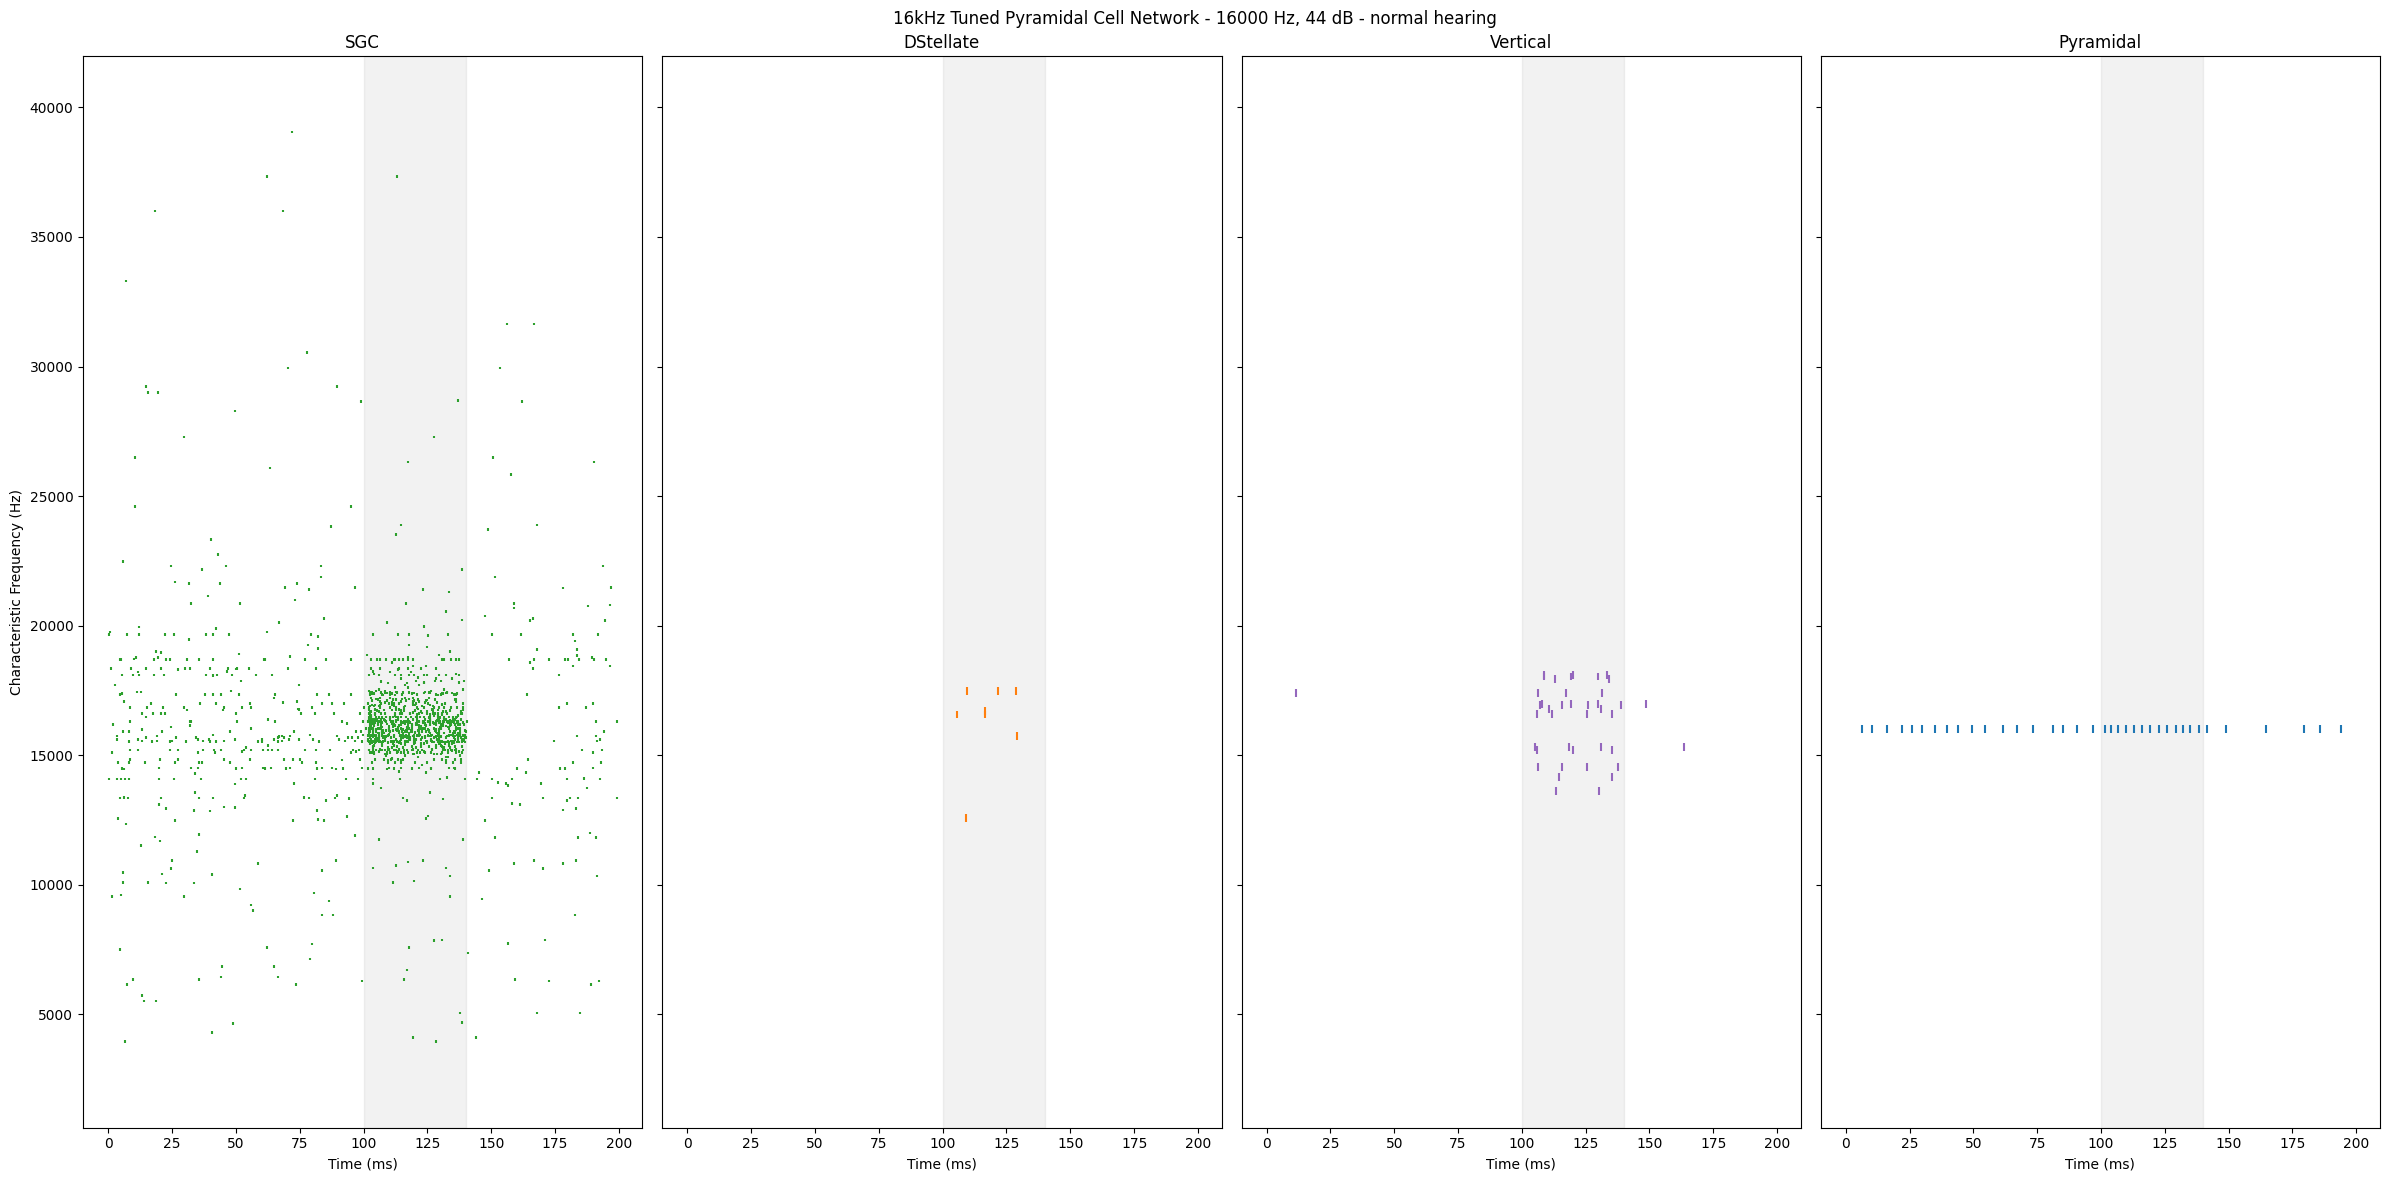

In [93]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 16000
level = 44

cell_count = 0
cells = results_od[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'16kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - normal hearing')

fig.tight_layout()


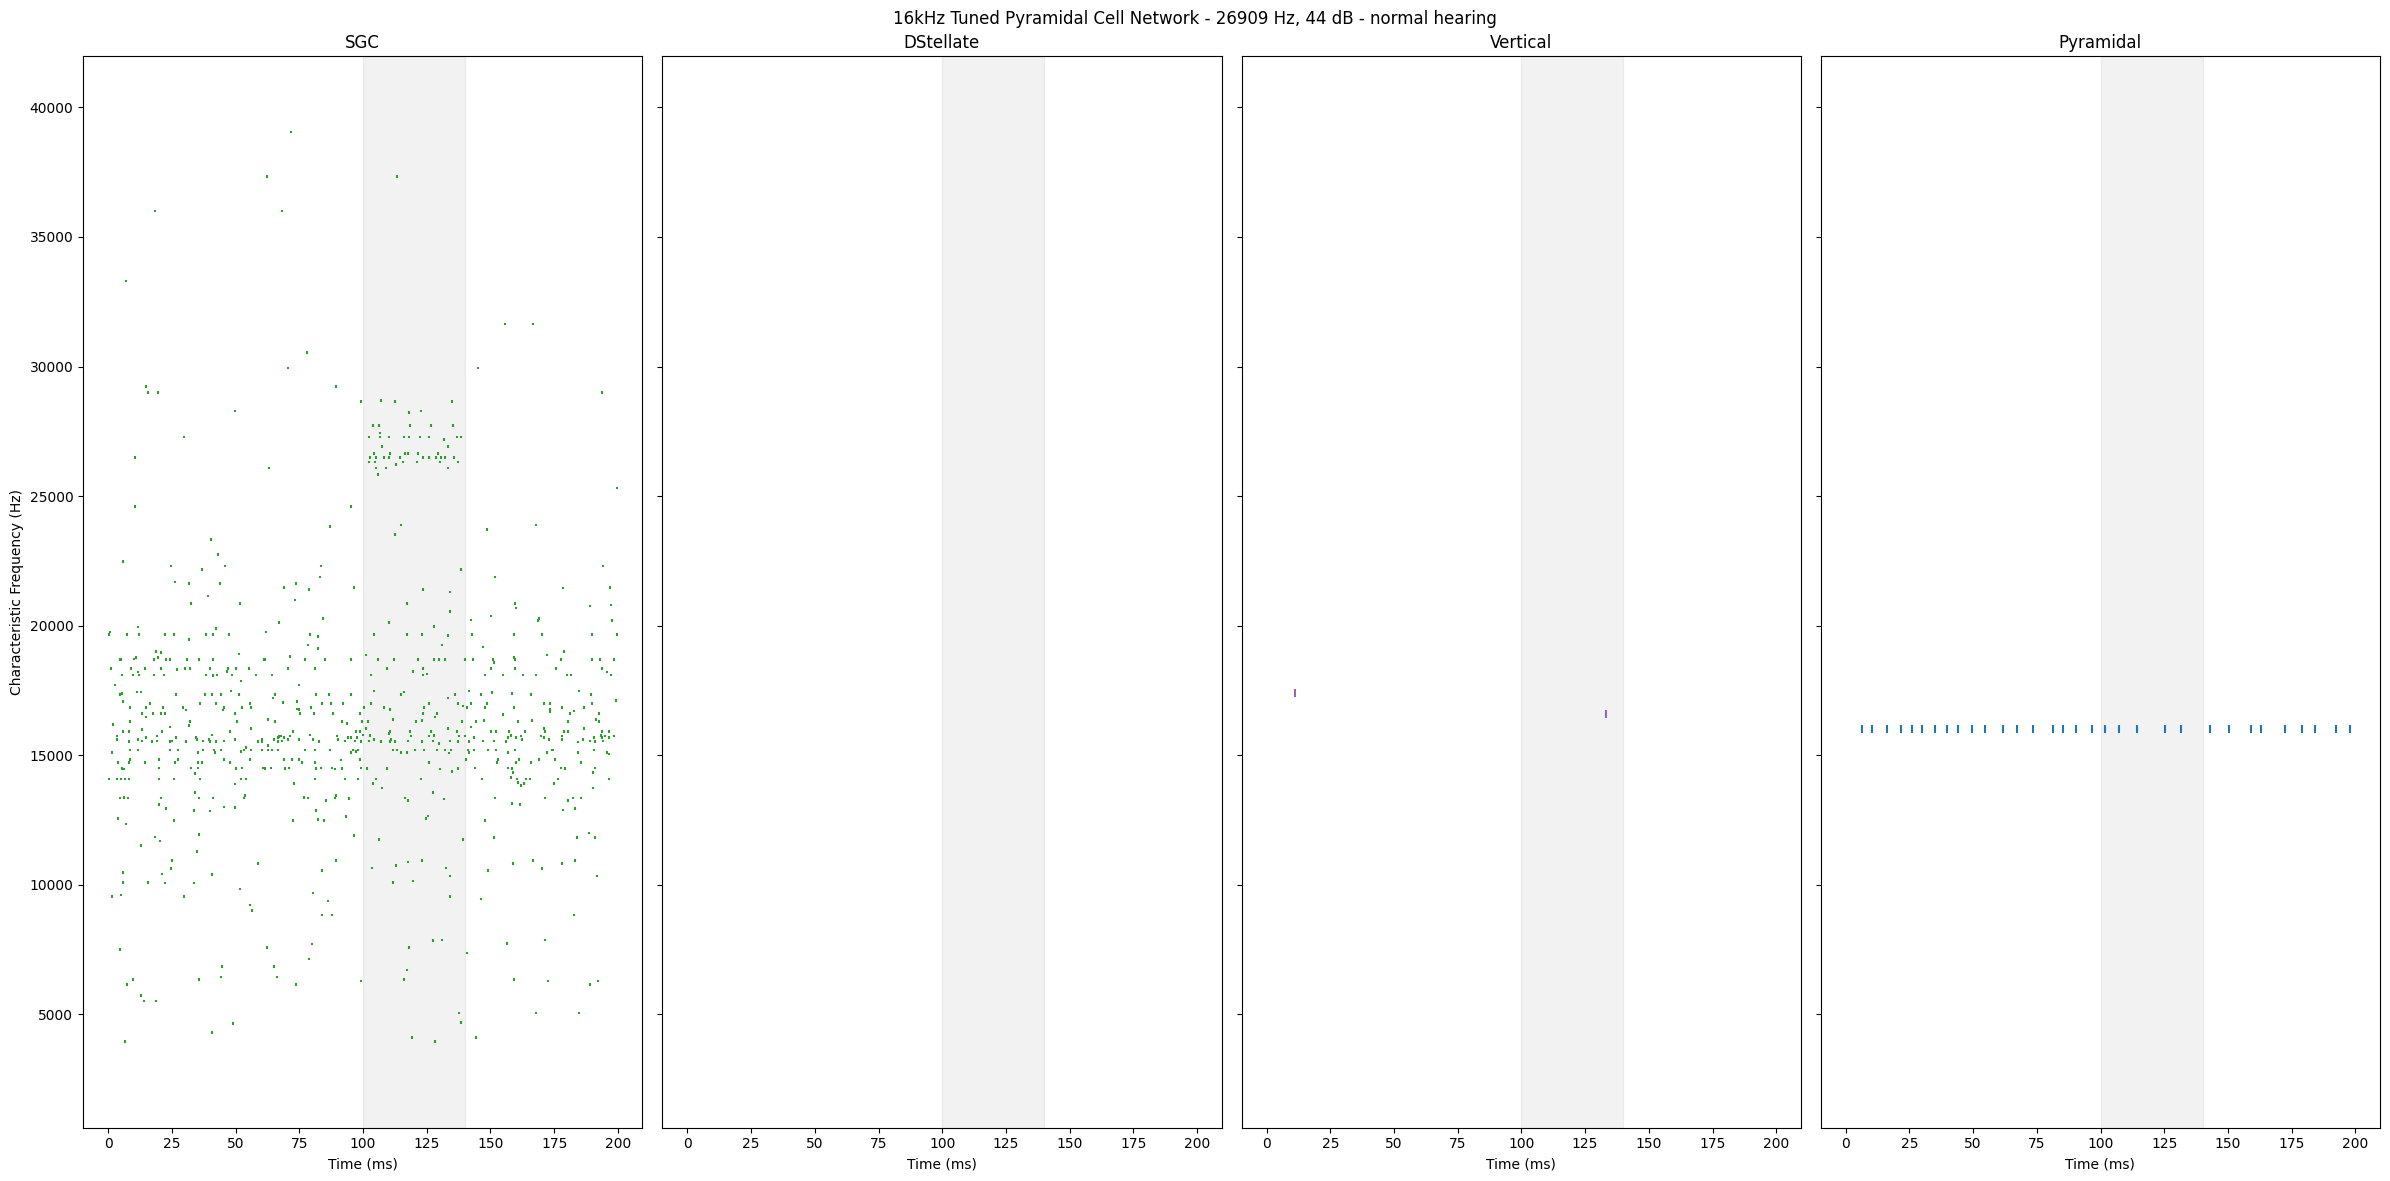

In [94]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 26909
level = 44

cell_count = 0
cells = results_od[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'16kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - normal hearing')

fig.tight_layout()


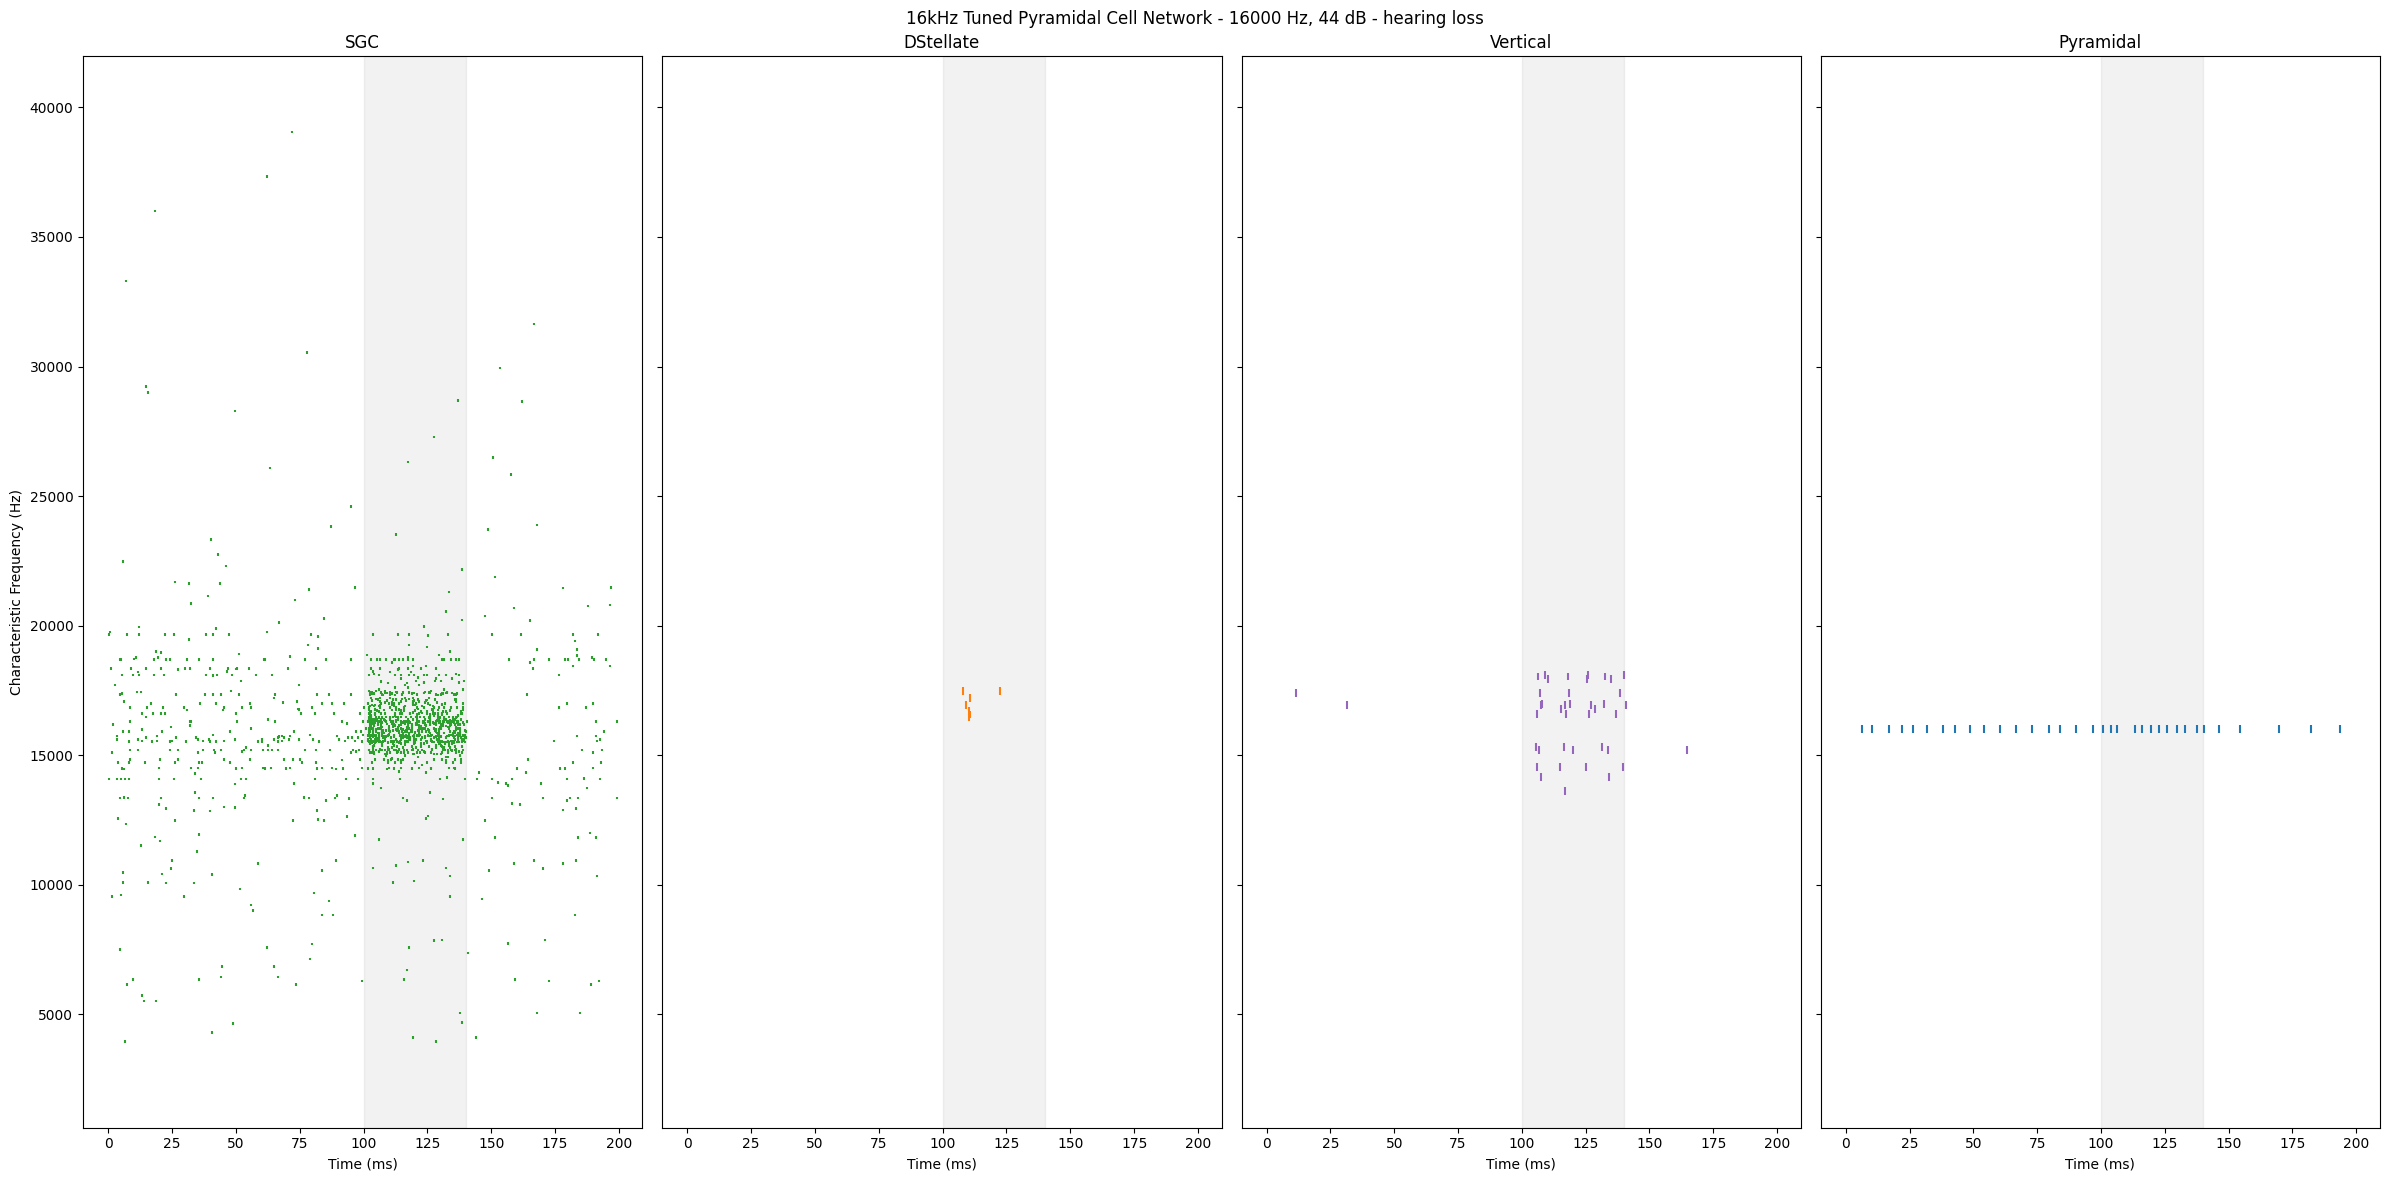

In [92]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 16000
level = 44

cell_count = 0
cells = results_od_loss_m1_95[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'16kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - hearing loss')

fig.tight_layout()


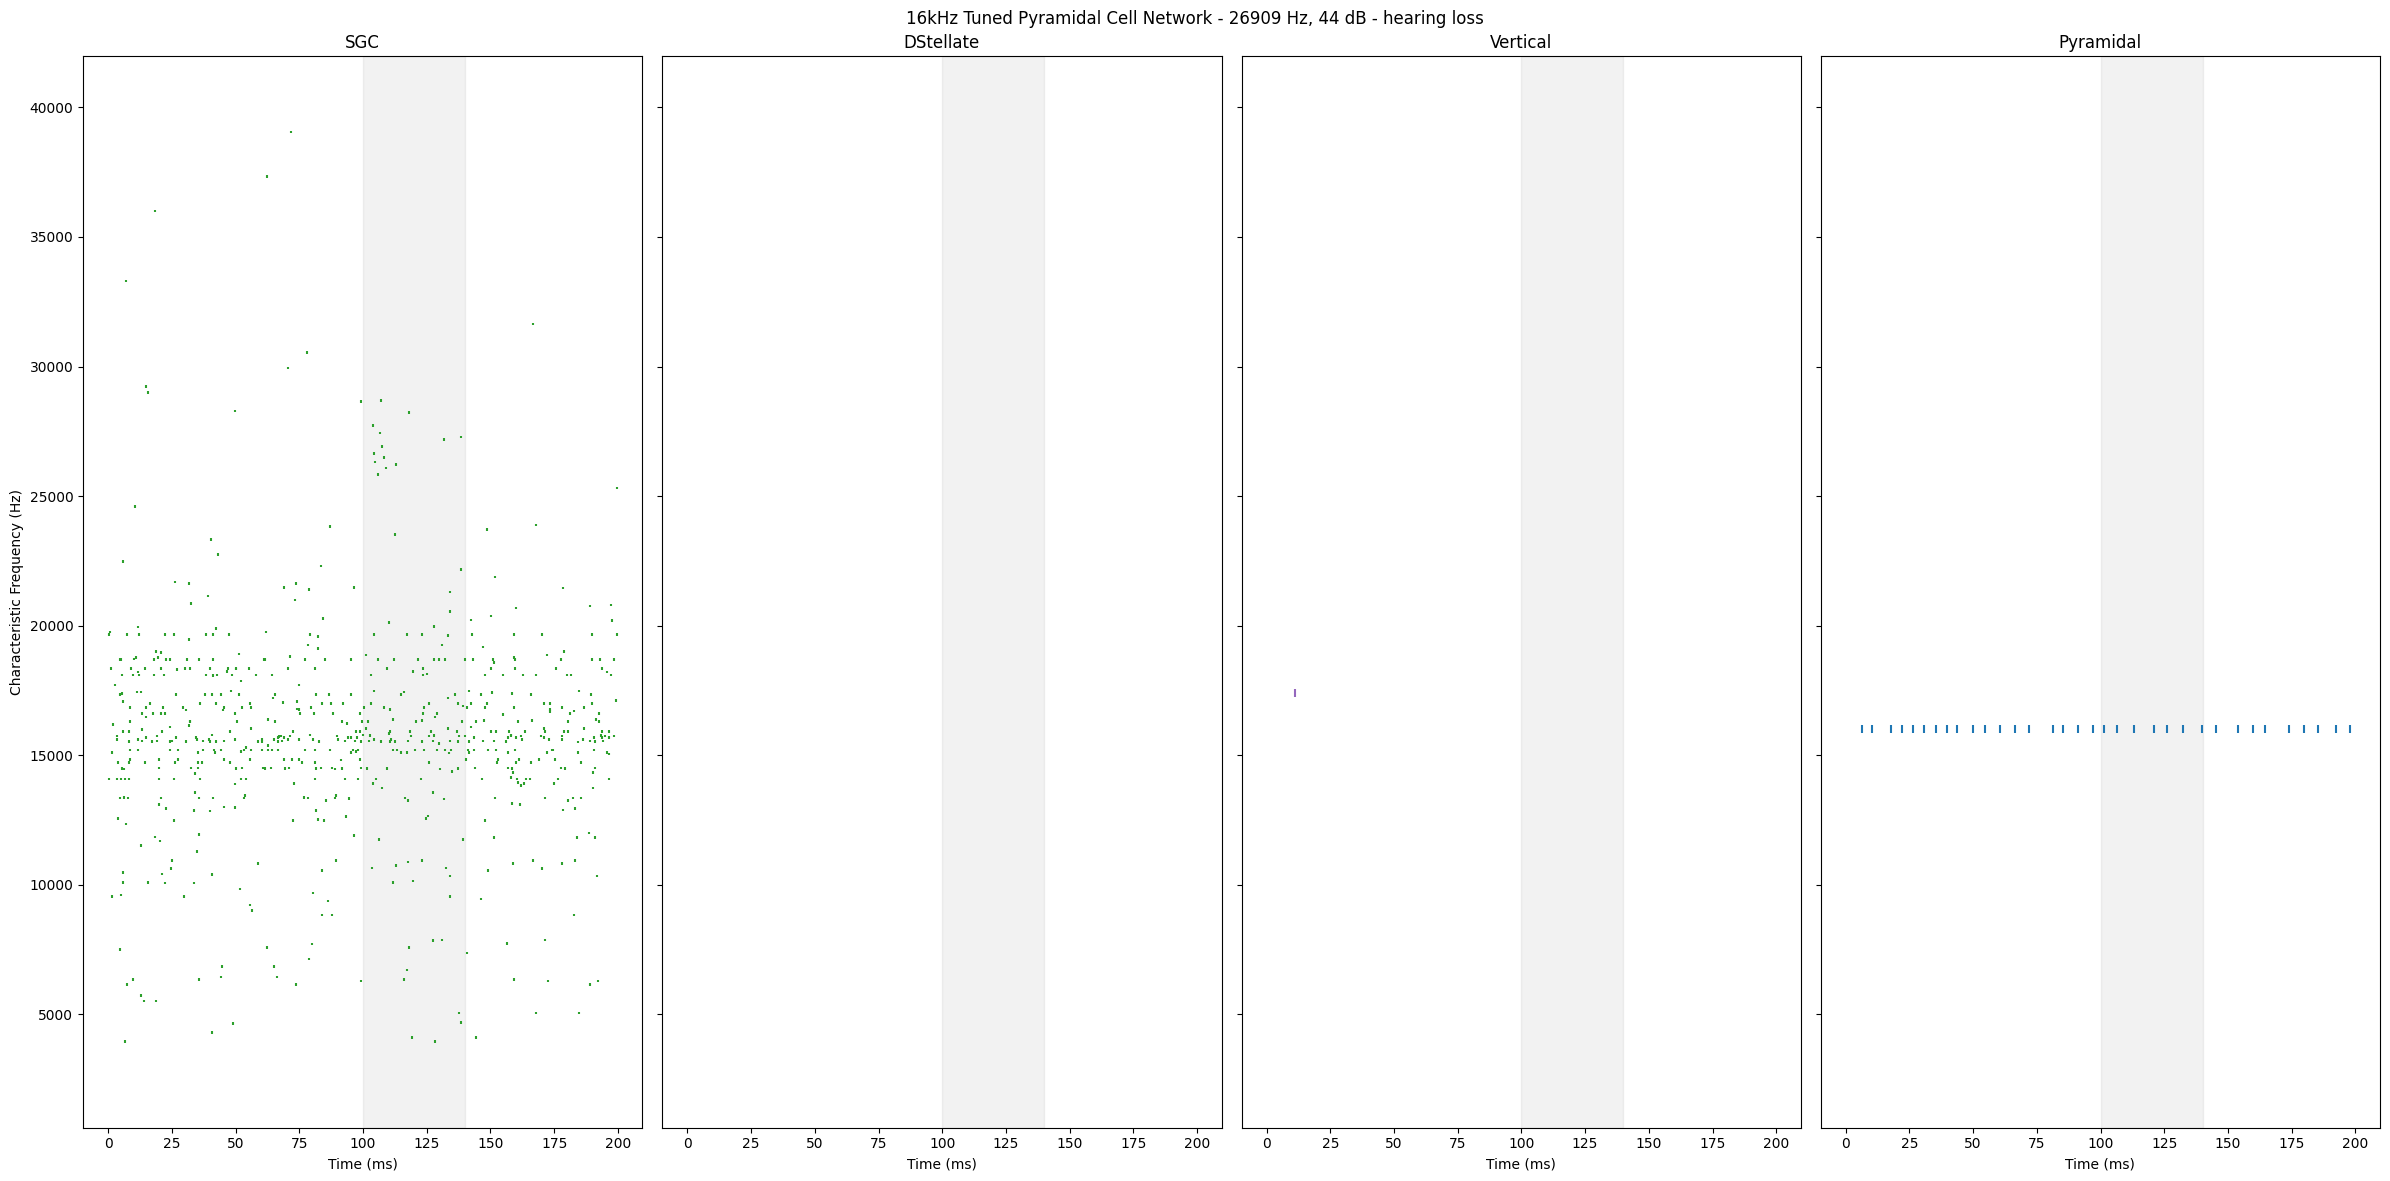

In [95]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 26909
level = 44

cell_count = 0
cells = results_od_loss_m1_95[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'16kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - hearing loss')

fig.tight_layout()


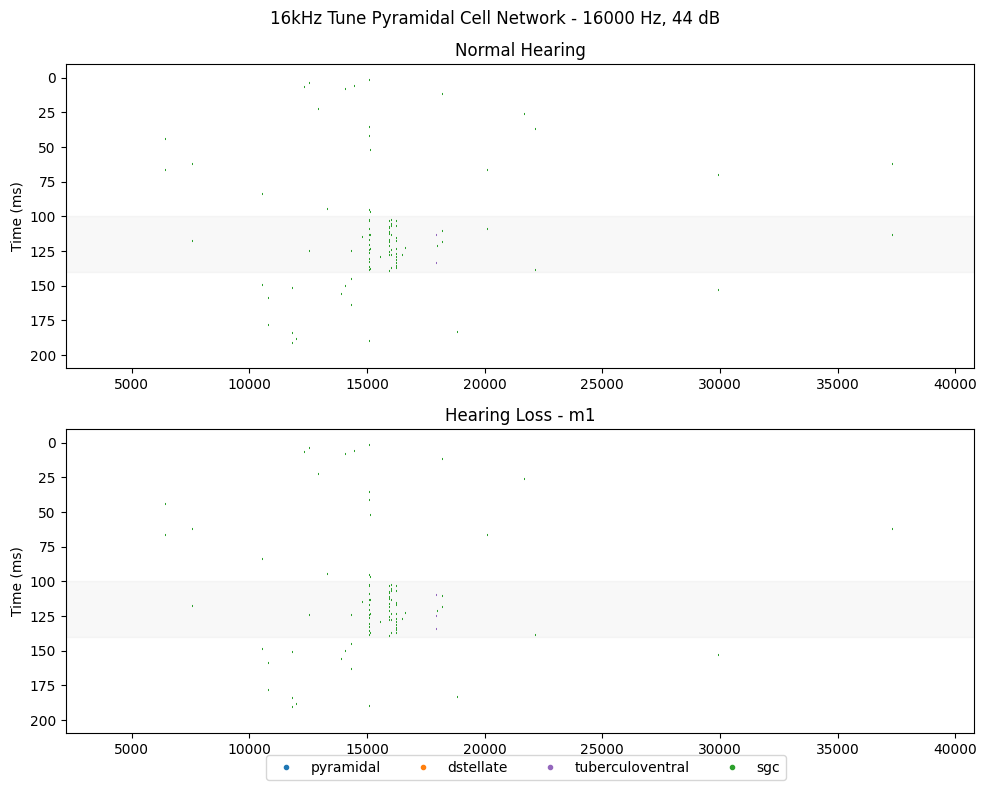

In [77]:
fig, axs = plt.subplots(2,1,figsize=(10,8))
axs = axs.ravel()
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

freq = 16000
level = 44

results_list = [results_od, results_od_loss_m1_95]
hearing = ['Normal Hearing', 'Hearing Loss - m1', 'Hearing Loss- m2']

for i, results in enumerate(results_list):

    cell_count = 0
    cells = results[f'f0: {freq}  dBspl: {level}'][1][0]

    for vec in cells.items():
        temp = 7
        if isinstance(vec[0], str):
            continue

        cell_type = vec[0][0]
        cell_id = vec[0][1]
        if 'sgc' in cell_type:
            temp = 6
        spikes = vec[1][1]
        # print(cell_count, len(spikes))
        xcen = pop_cfs[cell_type][cell_id]
        axs[i].hlines(spikes, xmin=xcen-0.25, xmax=xcen+3, colors=colors[cell_type], zorder=12)
        cell_count += 3

    # axs[0].axvspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].axhspan(100, 140, color='grey', alpha=0.05, zorder=1)
    # axs[i].set_xlim([-20, 2270])
    # axs[i].set_xticks([])
    axs[i].set_ylabel('Time (ms)')
    axs[i].invert_yaxis()
    axs[i].set_title(hearing[i])


custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
axs[-1].legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'16kHz Tune Pyramidal Cell Network - {freq} Hz, {level} dB')

fig.tight_layout()



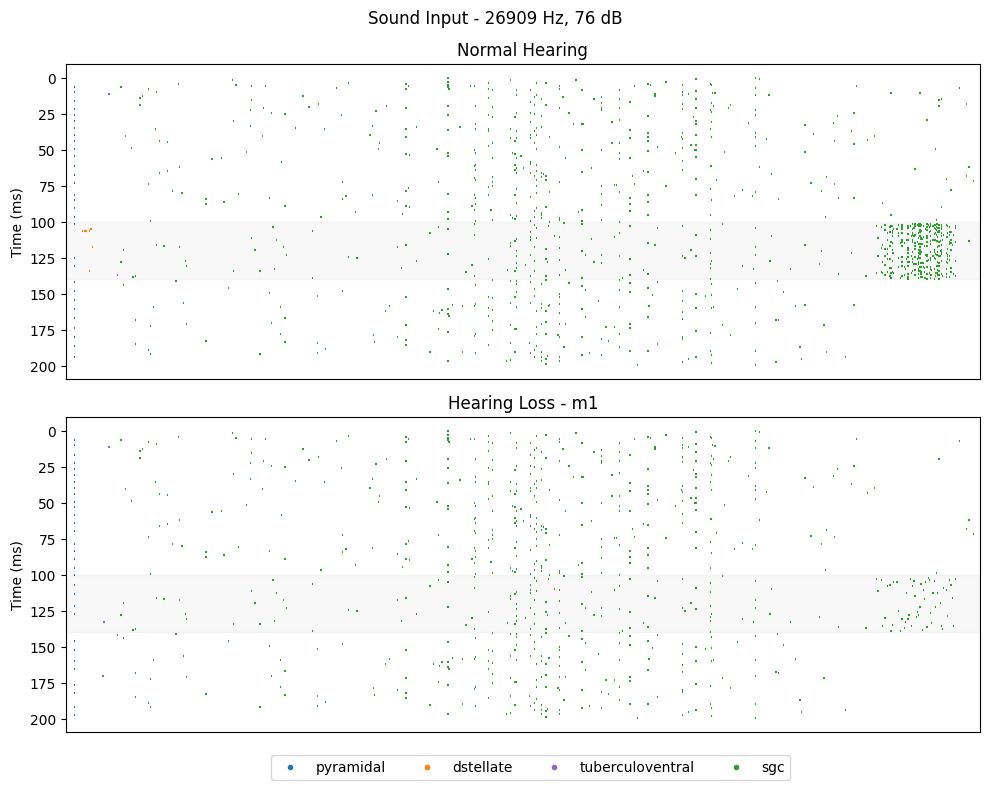

In [ ]:

fig, axs = plt.subplots(2,1,figsize=(10,8))
axs = axs.ravel()
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

freq = 26909
level = 76

results_list = [results_od, results_od_loss_m1_95]
hearing = ['Normal Hearing', 'Hearing Loss - m1', 'Hearing Loss- m2']

for i, results in enumerate(results_list):

    cell_count = 0
    cells = results[f'f0: {freq}  dBspl: {level}'][1][0]

    for vec in cells.items():
        temp = 7
        cell_type = vec[0][0]
        if isinstance(vec[0], str):
            continue
        spikes = vec[1][1]

        axs[i].hlines(spikes, xmin=cell_count-0.25, xmax=cell_count+3, colors=colors[cell_type], zorder=12)
        cell_count += 3

    axs[i].axhspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].set_xlim([-20, 2270])
    axs[i].set_xticks([])
    axs[i].set_ylabel('Time (ms)')
    axs[i].invert_yaxis()
    axs[i].set_title(hearing[i])

custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
axs[-1].legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'Sound Input - {freq} Hz, {level} dB')

fig.tight_layout()



## 24 kHz tuned pyramidal

In [96]:
results_od = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell/25fs_11dbs_24000cf-results_od.pkl', 'rb'))
results_od_loss_m1_95 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m1_95/25fs_11dbs_24000cf-results_od.pkl', 'rb'))
# results_od_loss_m2 = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss-m2/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

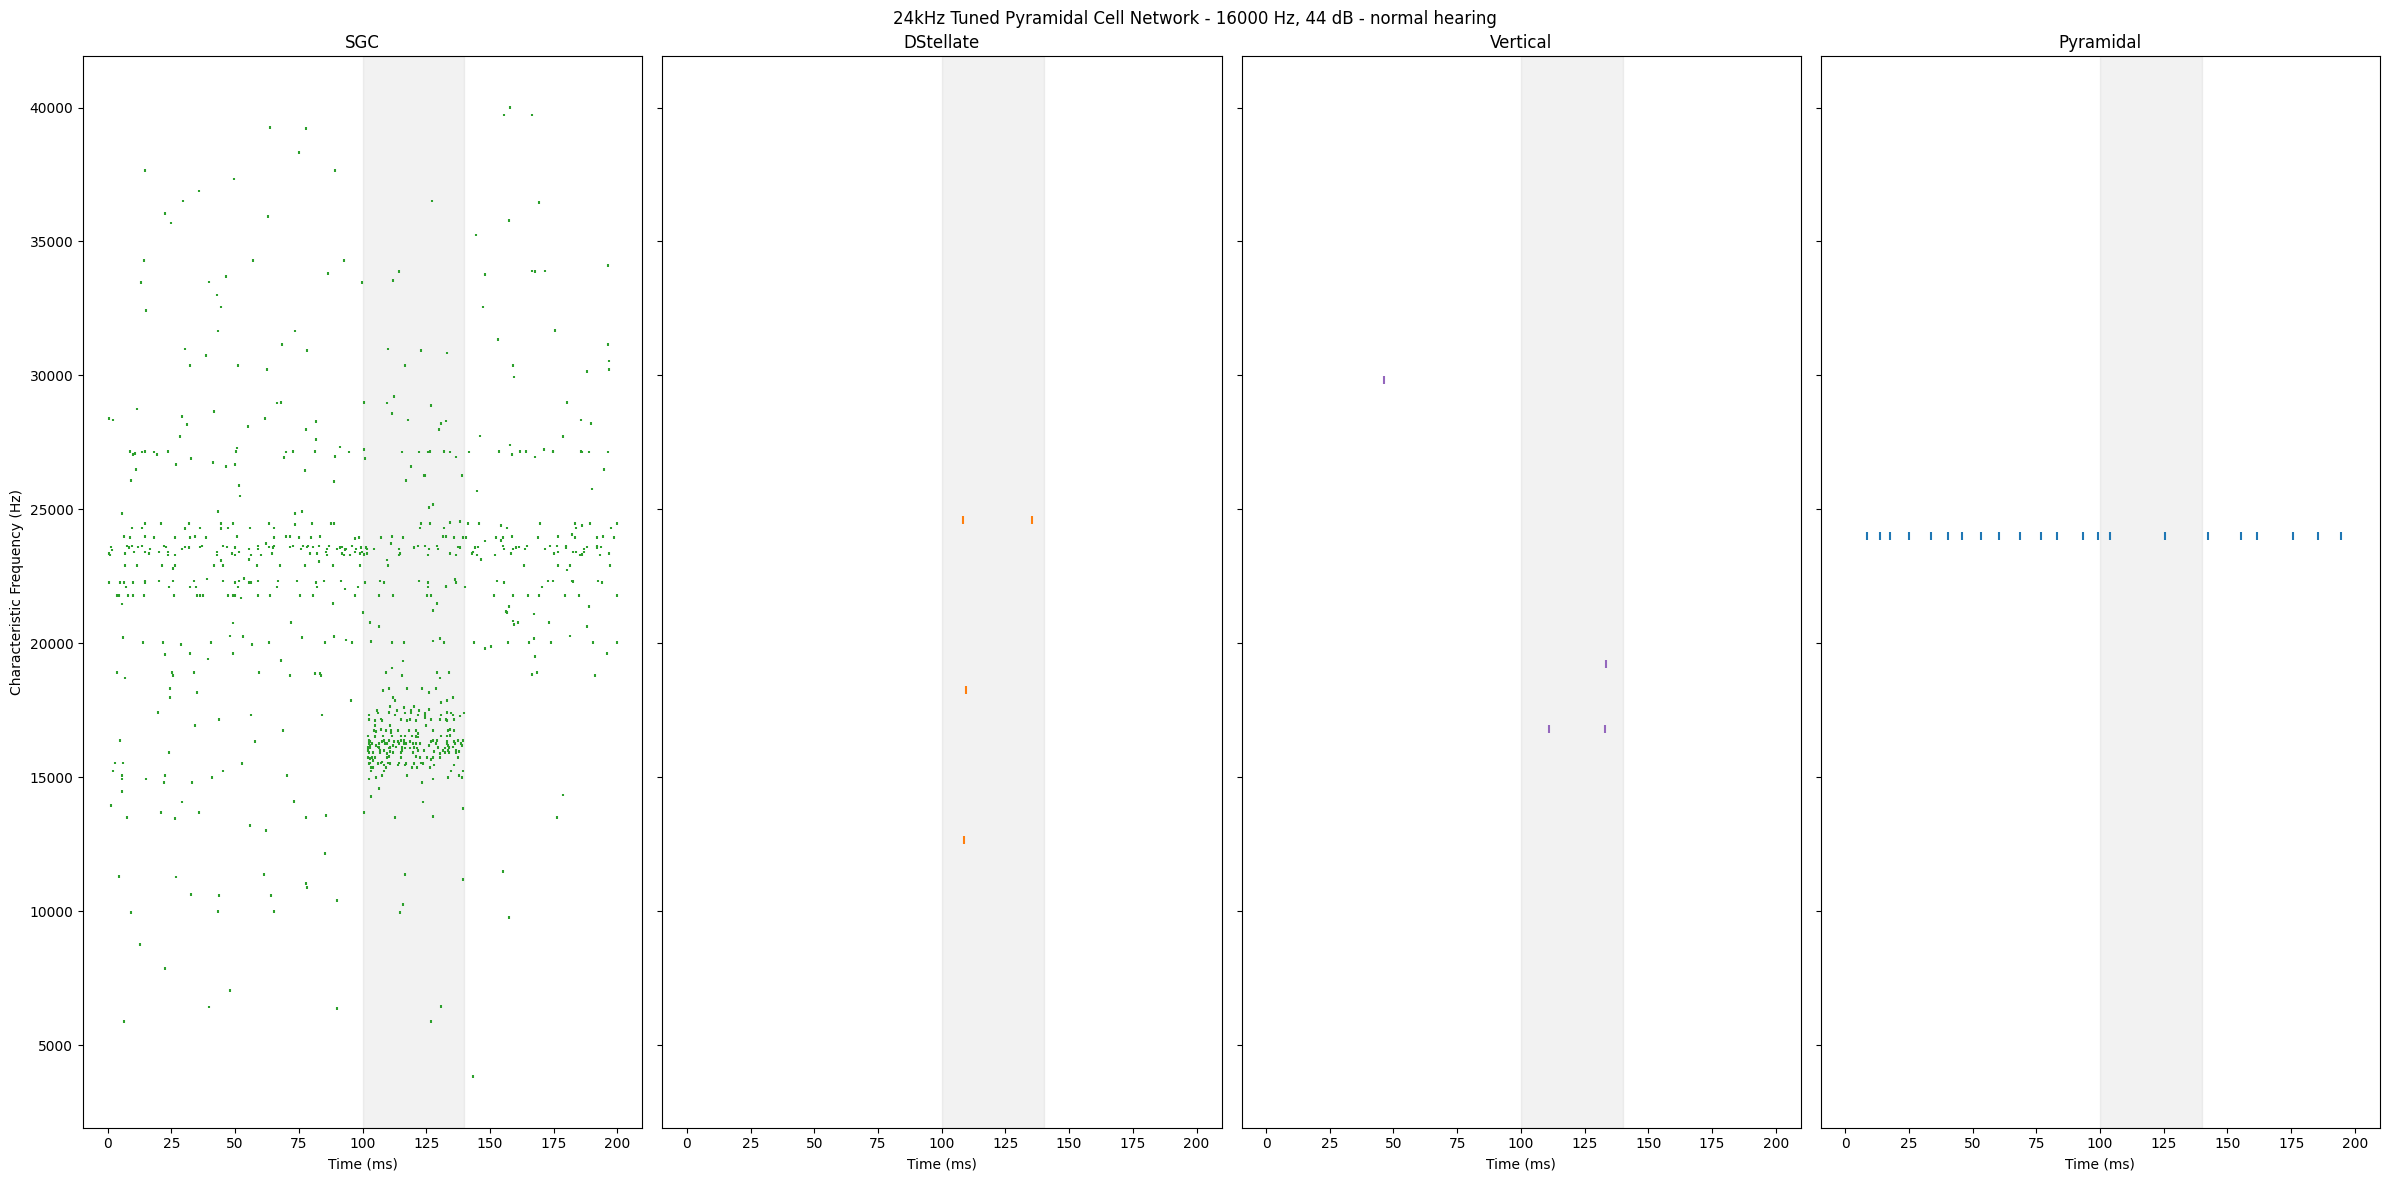

In [97]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 16000
level = 44

cell_count = 0
cells = results_od[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'24kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - normal hearing')

fig.tight_layout()


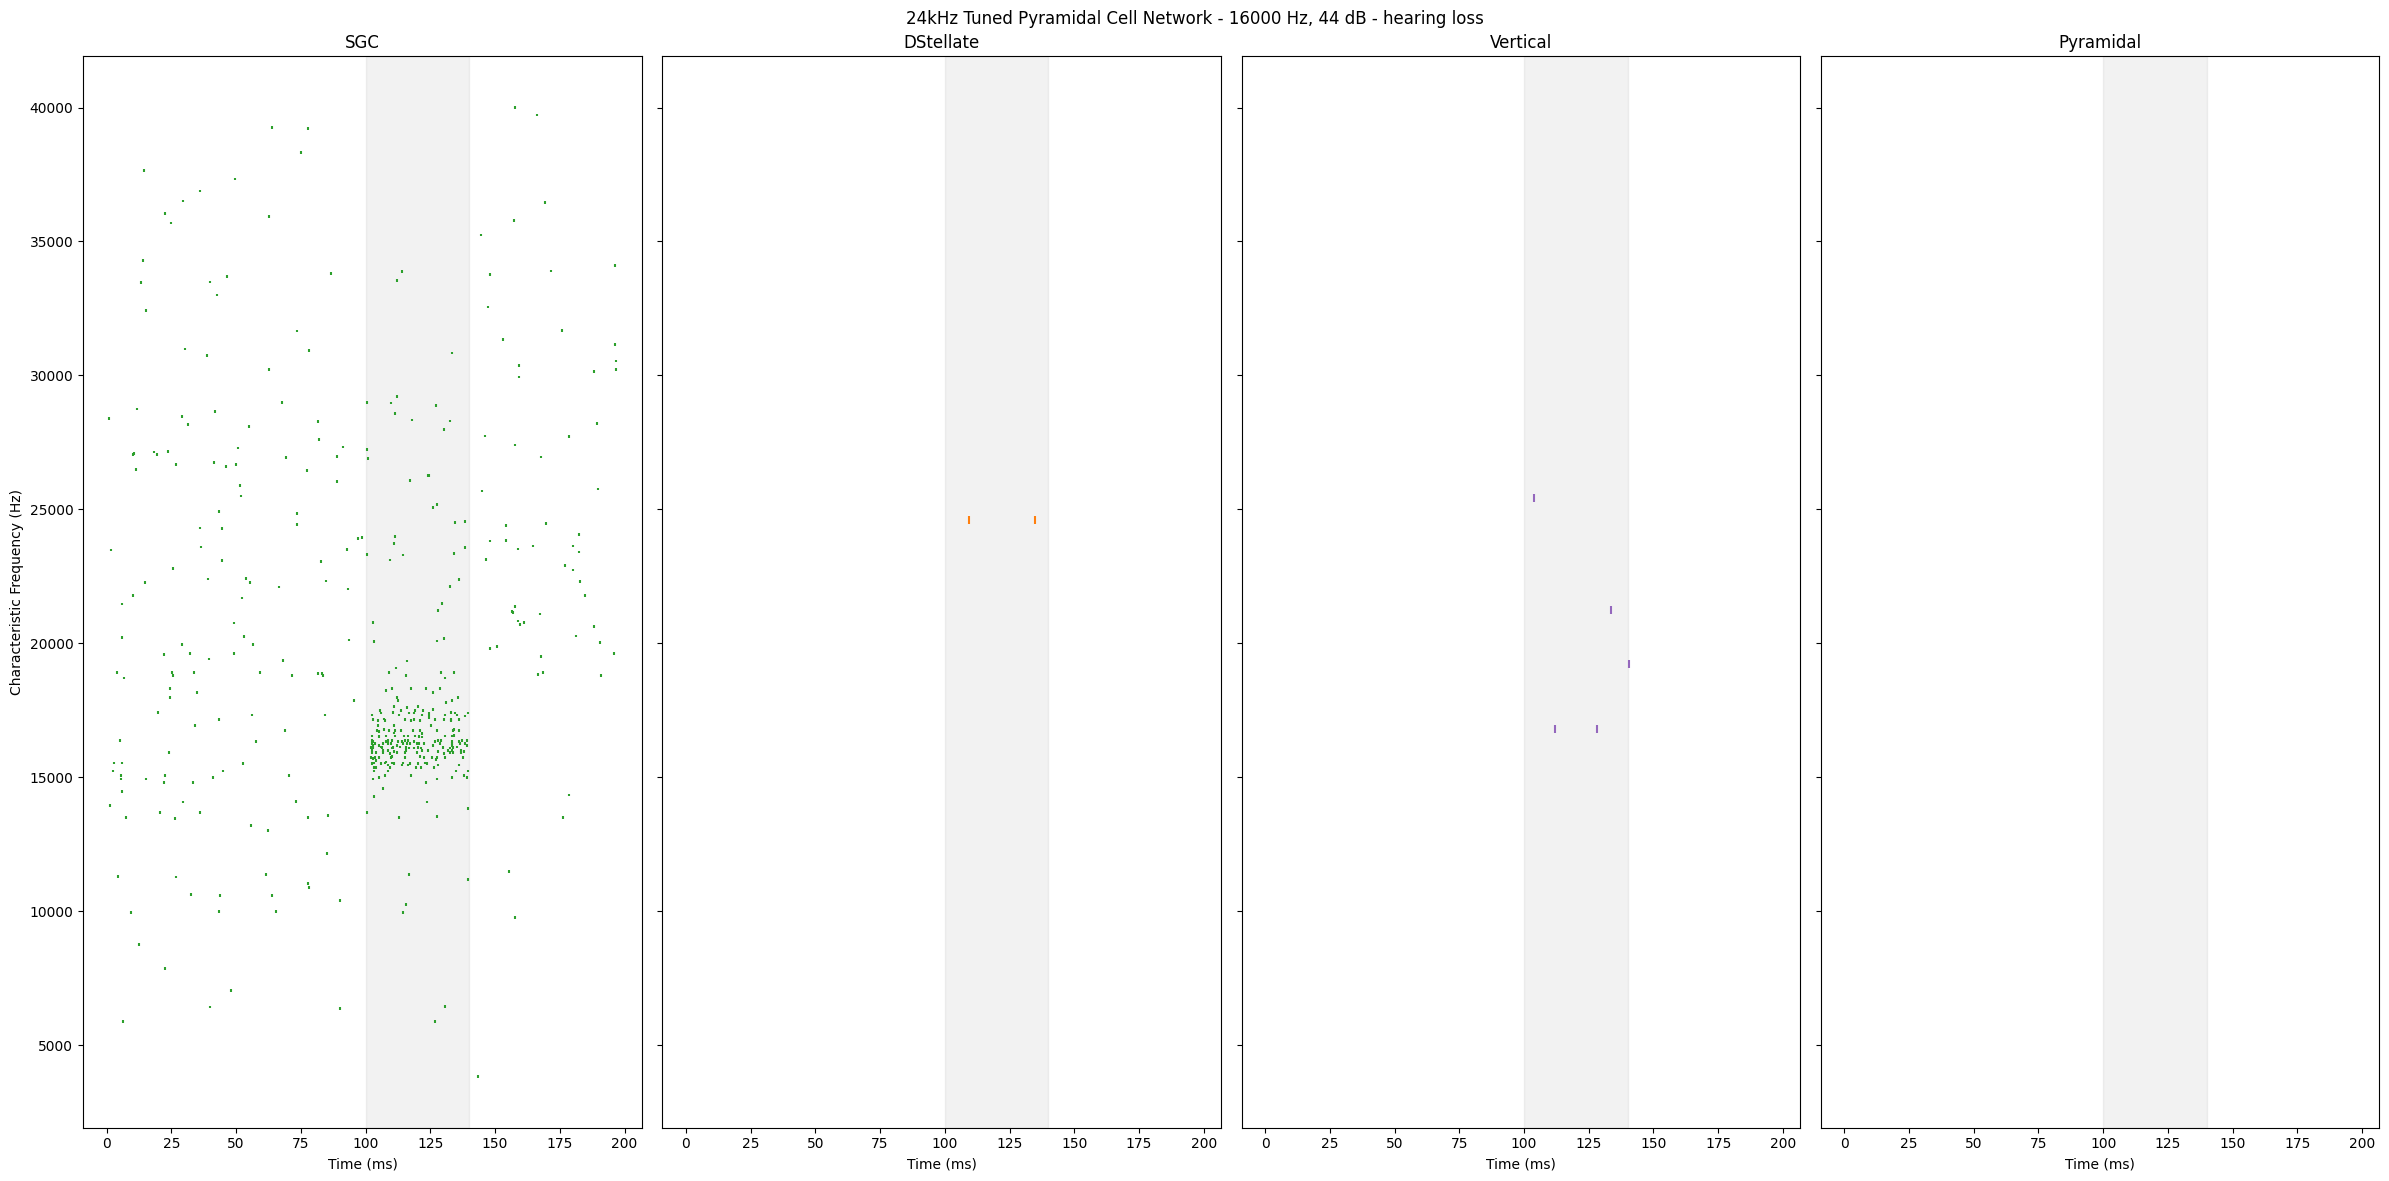

In [98]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 16000
level = 44

cell_count = 0
cells = results_od_loss_m1_95[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'24kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - hearing loss')

fig.tight_layout()


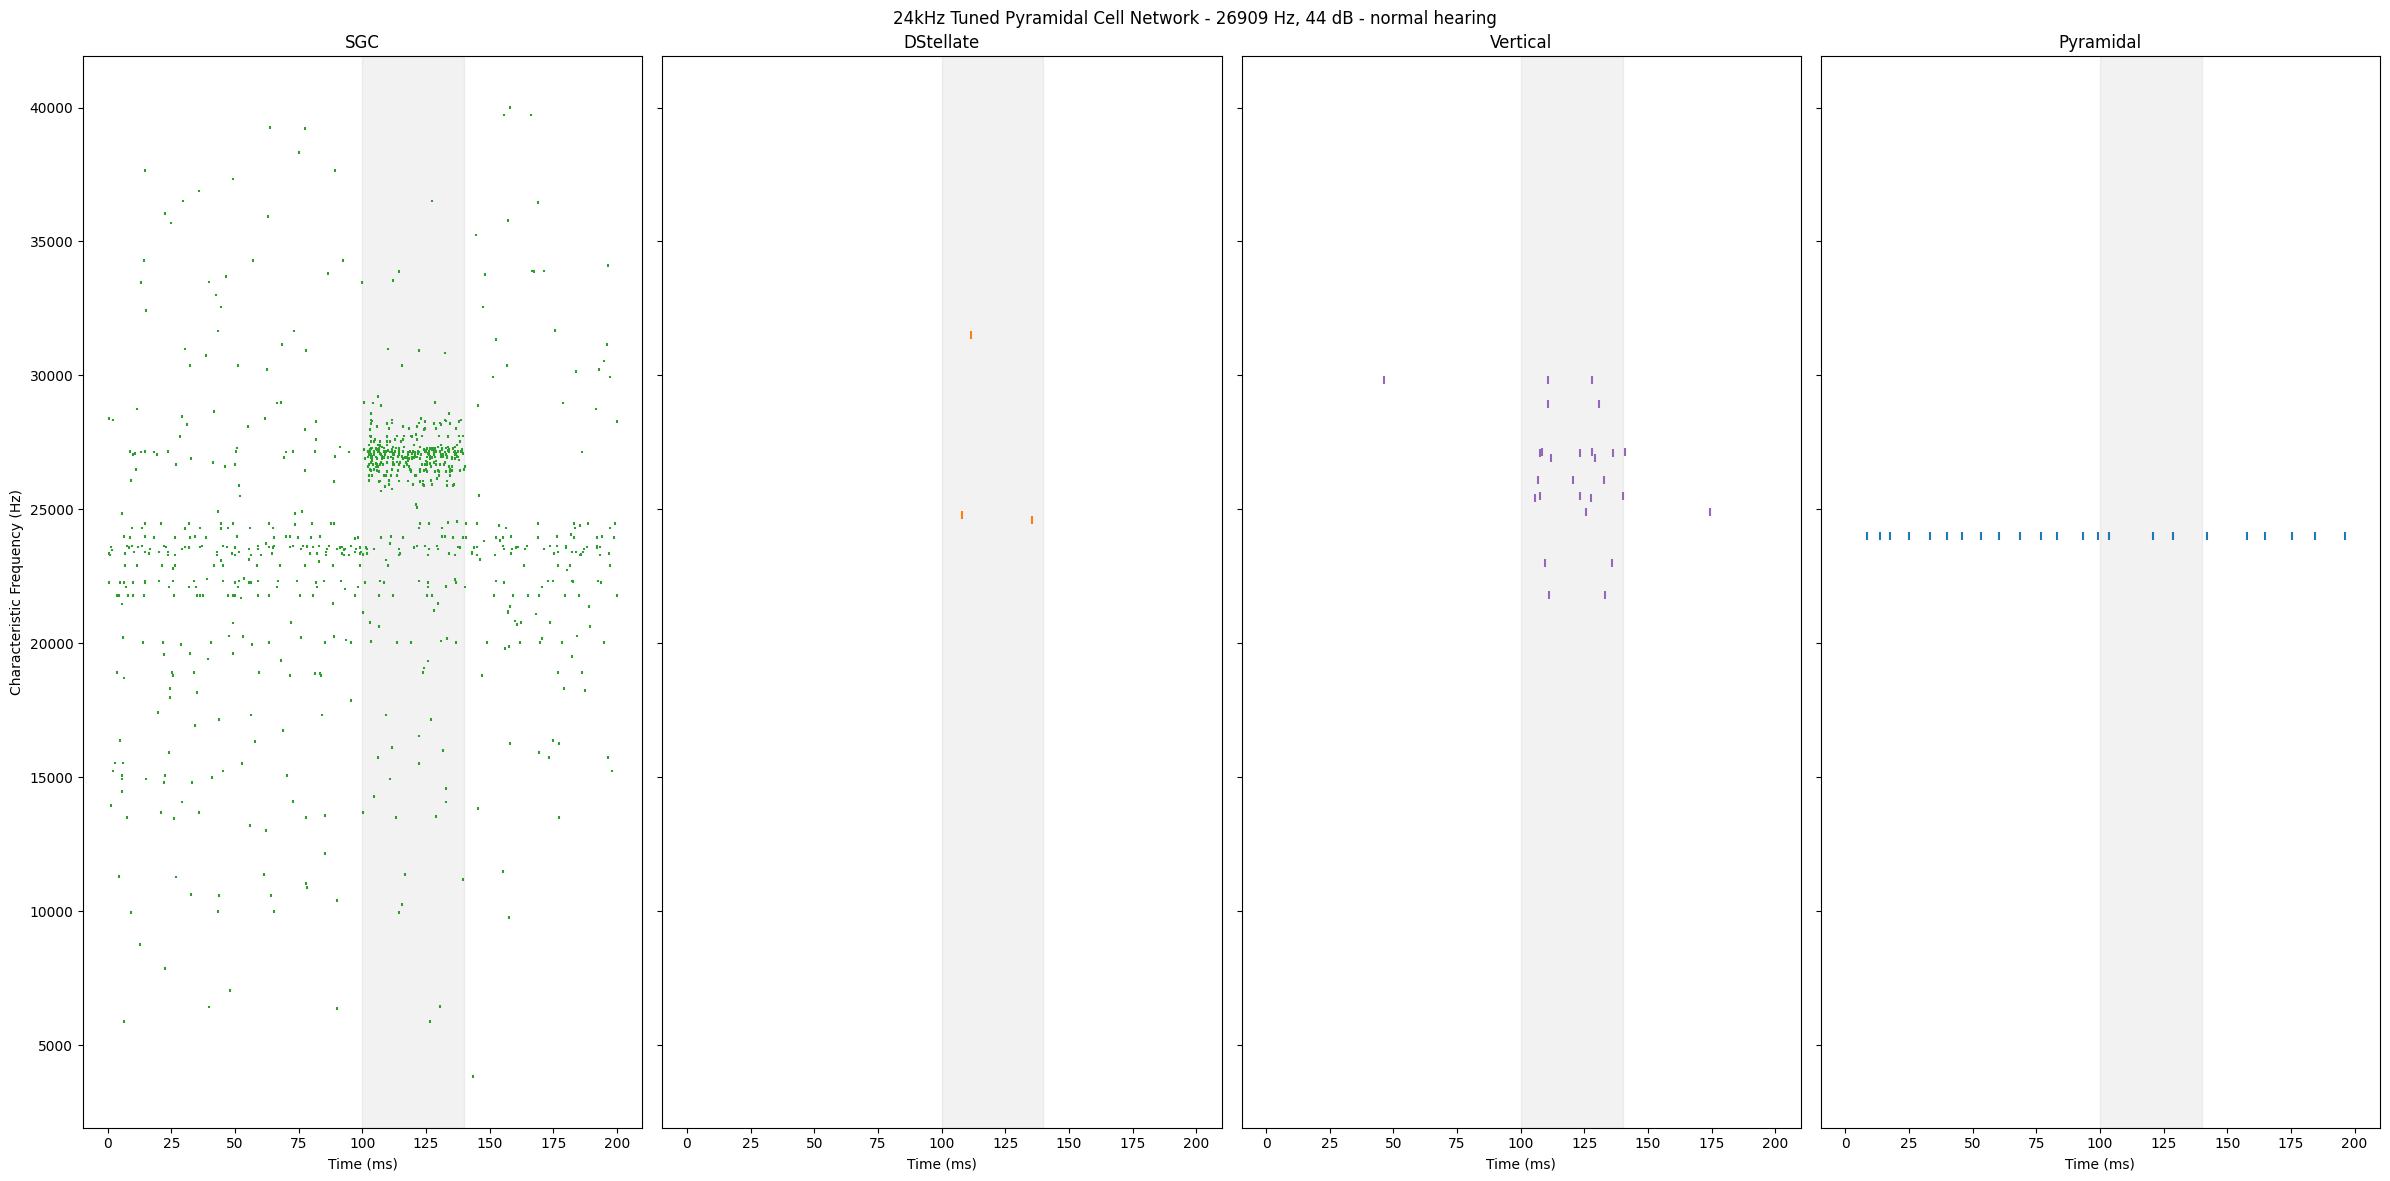

In [99]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 26909
level = 44

cell_count = 0
cells = results_od[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'24kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - normal hearing')

fig.tight_layout()


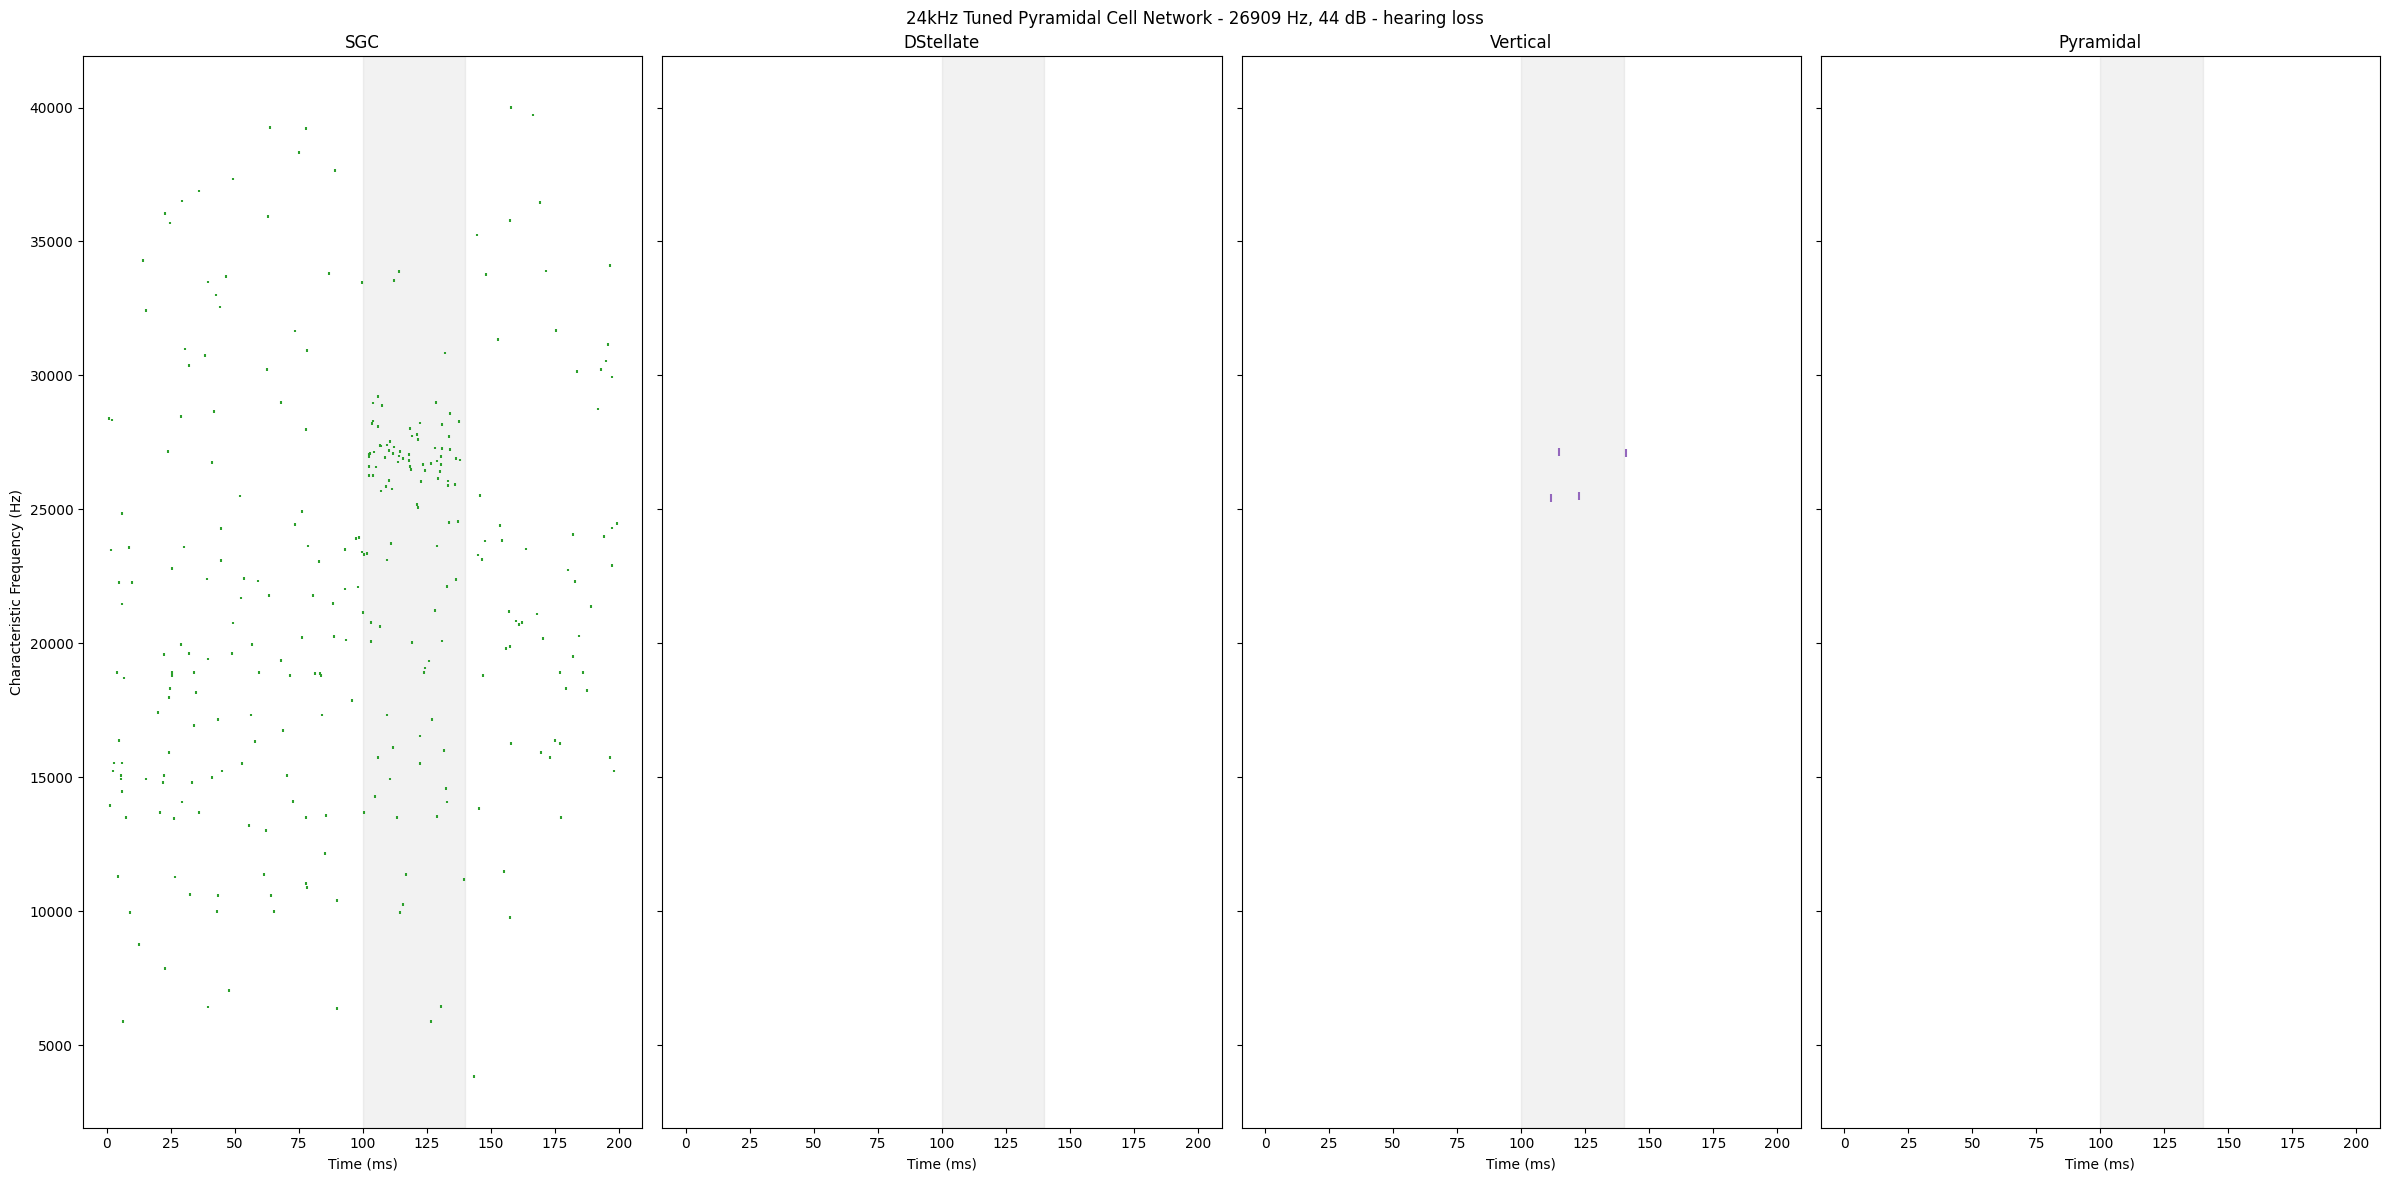

In [100]:

cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_ids = {cell_type: [] for cell_type in cell_types}
cell_spikes = {cell_type: [] for cell_type in cell_types}

freq = 26909
level = 44

cell_count = 0
cells = results_od_loss_m1_95[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    if isinstance(vec[0], str):
        continue

    cell_type = vec[0][0]
    cell_id = vec[0][1]
    spikes = vec[1][1]

    cell_ids[cell_type].append(cell_id)
    cell_spikes[cell_type].append(spikes)

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

fig, axs = plt.subplots(1,len(cell_types),figsize=(6*len(cell_types),12), sharey=True, sharex=True)
# axs = axs.ravel()

axs[0].eventplot(cell_spikes['sgc'], lineoffsets=sgc_cfs[cell_ids['sgc']], linelengths=100, colors=colors['sgc'], zorder=12)#, colors='tab:red')
axs[0].set_title('SGC')

axs[1].eventplot(cell_spikes['dstellate'], lineoffsets=ds_cfs[cell_ids['dstellate']], linelengths=300, colors=colors['dstellate'], zorder=12)
axs[1].set_title('DStellate')

axs[2].eventplot(cell_spikes['tuberculoventral'], lineoffsets=vert_cfs[cell_ids['tuberculoventral']], linelengths=300, colors=colors['tuberculoventral'], zorder=12)
axs[2].set_title('Vertical')

axs[3].eventplot(cell_spikes['pyramidal'], lineoffsets=pyr_cfs[cell_ids['pyramidal']], linelengths=300, colors=colors['pyramidal'], zorder=12)  
axs[3].set_title('Pyramidal')

for ax in axs:
    # ax.set_ylim([4e3, 40e3])
    ax.set_xlabel('Time (ms)')
    ax.axvspan(xmin=100, xmax=140, color='grey', alpha=0.1, zorder=1)

axs[0].set_ylabel('Characteristic Frequency (Hz)')

# custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
# axs.legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'24kHz Tuned Pyramidal Cell Network - {freq} Hz, {level} dB - hearing loss')

fig.tight_layout()


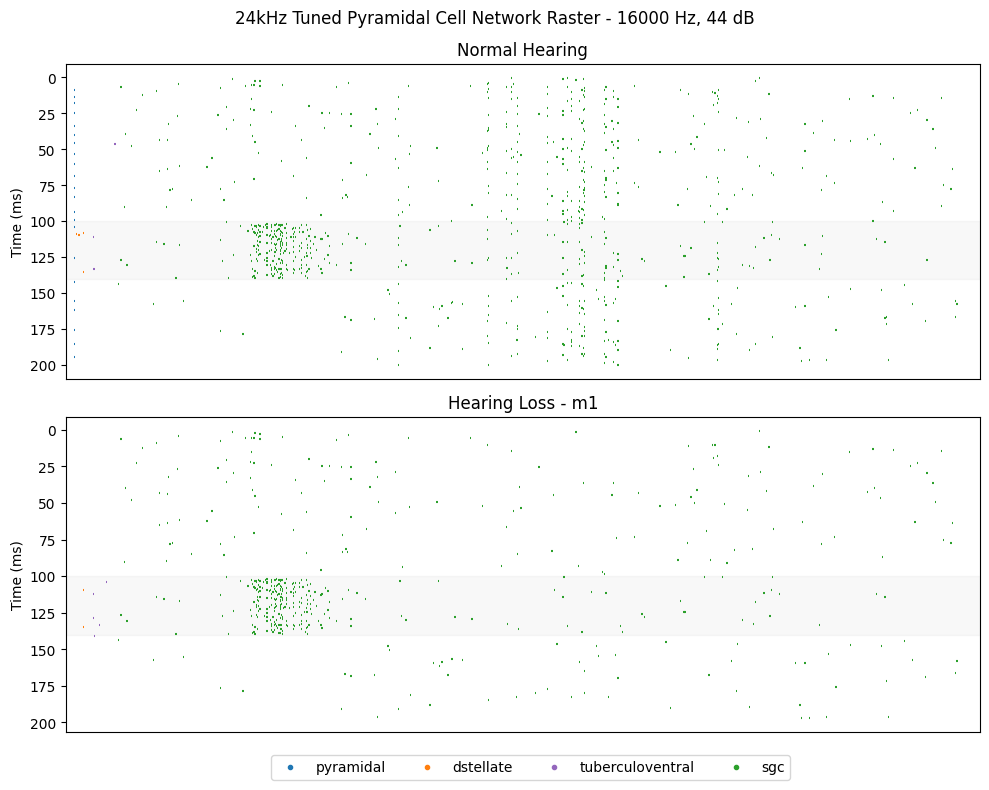

In [15]:
fig, axs = plt.subplots(2,1,figsize=(10,8))
axs = axs.ravel()
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

freq = 16000
level = 44

results_list = [results_od, results_od_loss_m1_95]
hearing = ['Normal Hearing', 'Hearing Loss - m1', 'Hearing Loss- m2']

for i, results in enumerate(results_list):

    cell_count = 0
    cells = results[f'f0: {freq}  dBspl: {level}'][1][0]

    for vec in cells.items():
        temp = 7
        cell_type = vec[0][0]
        if isinstance(vec[0], str):
            continue
        spikes = vec[1][1]

        axs[i].hlines(spikes, xmin=cell_count-0.25, xmax=cell_count+3, colors=colors[cell_type], zorder=12)
        cell_count += 3

    # axs[0].axvspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].axhspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].set_xlim([-20, 2270])
    axs[i].set_xticks([])
    axs[i].set_ylabel('Time (ms)')
    axs[i].invert_yaxis()
    axs[i].set_title(hearing[i])


custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
axs[-1].legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'24kHz Tuned Pyramidal Cell Network Raster - {freq} Hz, {level} dB')

fig.tight_layout()

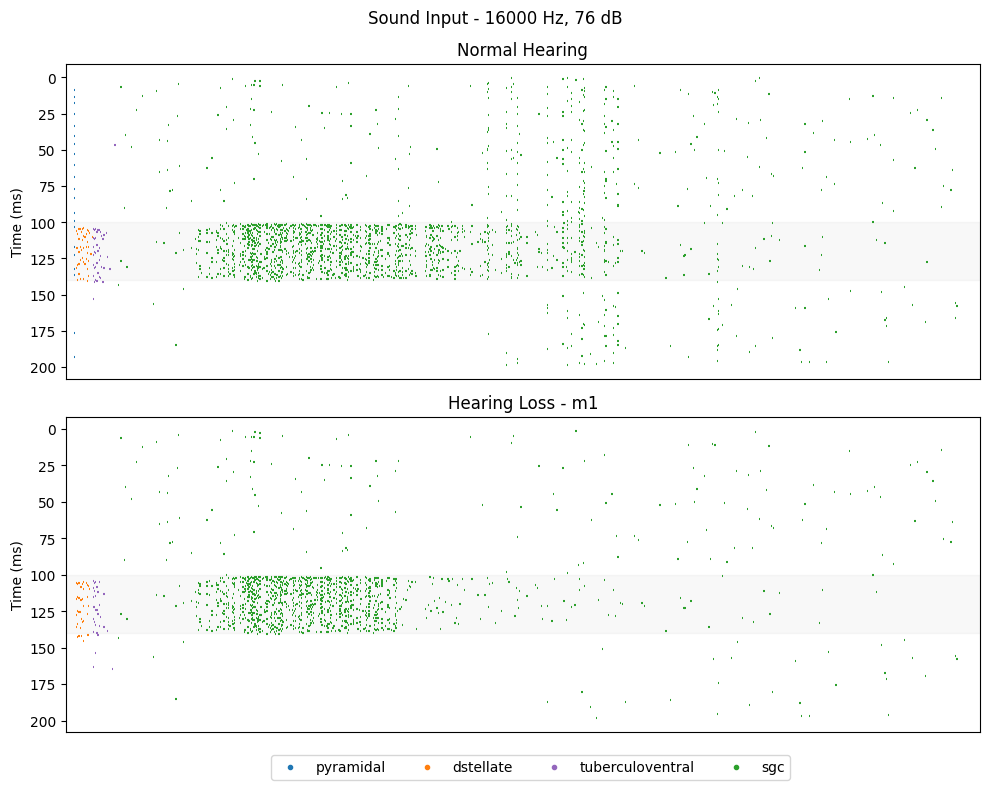

In [9]:
fig, axs = plt.subplots(2,1,figsize=(10,8))
axs = axs.ravel()
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

freq = 16000
level = 76

results_list = [results_od, results_od_loss_m1_95]
hearing = ['Normal Hearing', 'Hearing Loss - m1', 'Hearing Loss- m2']

for i, results in enumerate(results_list):

    cell_count = 0
    cells = results[f'f0: {freq}  dBspl: {level}'][1][0]

    for vec in cells.items():
        temp = 7
        cell_type = vec[0][0]
        if isinstance(vec[0], str):
            continue
        spikes = vec[1][1]

        axs[i].hlines(spikes, xmin=cell_count-0.25, xmax=cell_count+3, colors=colors[cell_type], zorder=12)
        cell_count += 3

    # axs[0].axvspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].axhspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].set_xlim([-20, 2270])
    axs[i].set_xticks([])
    axs[i].set_ylabel('Time (ms)')
    axs[i].invert_yaxis()
    axs[i].set_title(hearing[i])


custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
axs[-1].legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'Sound Input - {freq} Hz, {level} dB')

fig.tight_layout()

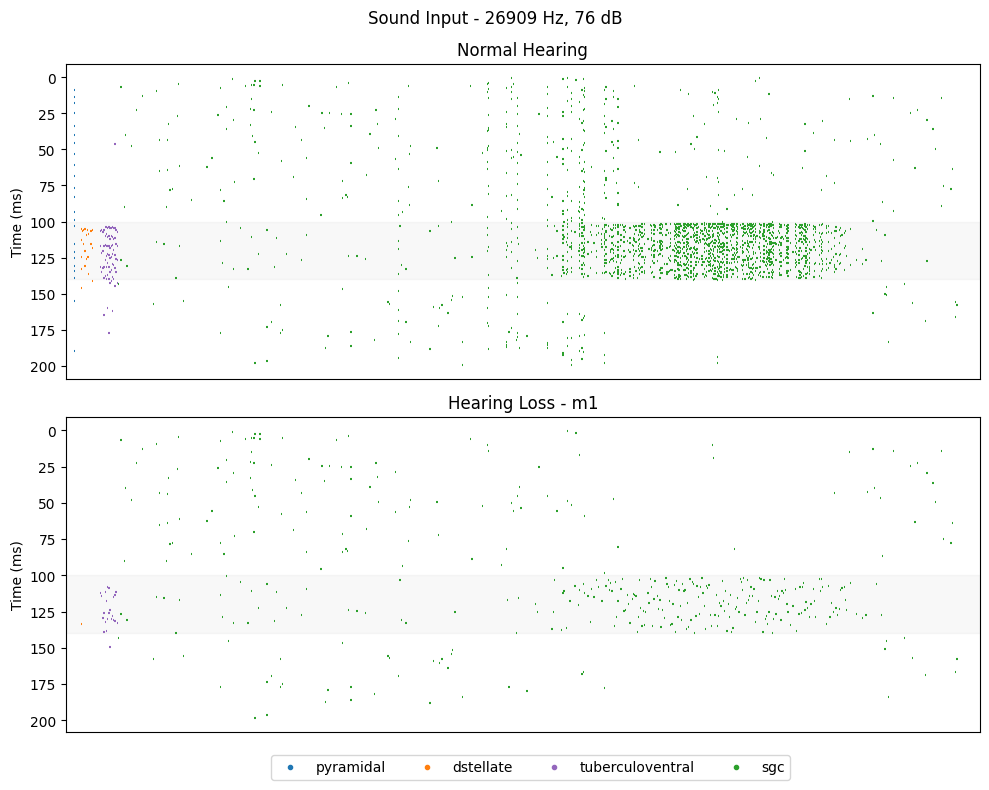

In [10]:

fig, axs = plt.subplots(2,1,figsize=(10,8))
axs = axs.ravel()
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

freq = 26909
level = 76

results_list = [results_od, results_od_loss_m1_95]
hearing = ['Normal Hearing', 'Hearing Loss - m1', 'Hearing Loss- m2']

for i, results in enumerate(results_list):

    cell_count = 0
    cells = results[f'f0: {freq}  dBspl: {level}'][1][0]

    for vec in cells.items():
        temp = 7
        cell_type = vec[0][0]
        if isinstance(vec[0], str):
            continue
        spikes = vec[1][1]

        axs[i].hlines(spikes, xmin=cell_count-0.25, xmax=cell_count+3, colors=colors[cell_type], zorder=12)
        cell_count += 3

    axs[i].axhspan(100, 140, color='grey', alpha=0.05, zorder=1)
    axs[i].set_xlim([-20, 2270])
    axs[i].set_xticks([])
    axs[i].set_ylabel('Time (ms)')
    axs[i].invert_yaxis()
    axs[i].set_title(hearing[i])

custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
axs[-1].legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'Sound Input - {freq} Hz, {level} dB')

fig.tight_layout()



## Other

In [6]:
stim = results_od['f0: 4000  dBspl: 44'][0]
cells = results_od['f0: 4000  dBspl: 44'][1]

In [107]:


cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']
cell_spkts = {cell_type: [] for cell_type in cell_types}

for cell_info, cell_data in cells[0].items():
    if isinstance(cell_info, str):
        continue
    cell_type, cell_id = cell_info
    cell_v, cell_spkt = cell_data
    # print(cell_id)

    if len(cell_spkt) > 0:
        cell_spkts[cell_type].append((cell_id, cell_spkt))





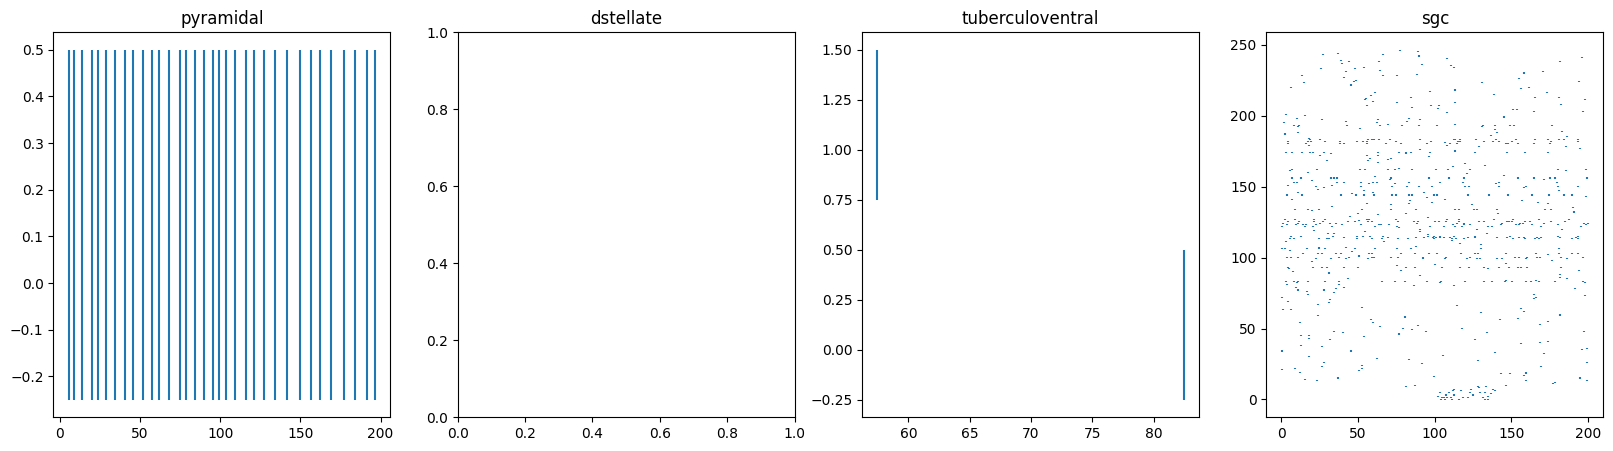

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(20,5))
axs = axs.ravel()

for i, (cell_type, cell_data) in enumerate(cell_spkts.items()):


    for j, spkts in enumerate(cell_data):

        axs[i].vlines(spkts[1], ymin=j-0.25, ymax=j+0.5)
        
    axs[i].set_title(cell_type)
    # axs[i].set_ylim([0,250])


In [95]:
colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_type_list = []
cell_spkt_list = []
cell_color_list = []

for vec in cells[0].items():
    temp = 7
    if isinstance(vec[0], str):
        continue
    cell_type = vec[0][0]
    spikes = vec[1][1]
    cell_type_list.append(cell_type)
    cell_spkt_list.append(spikes)
    cell_color_list.append(colors[cell_type])




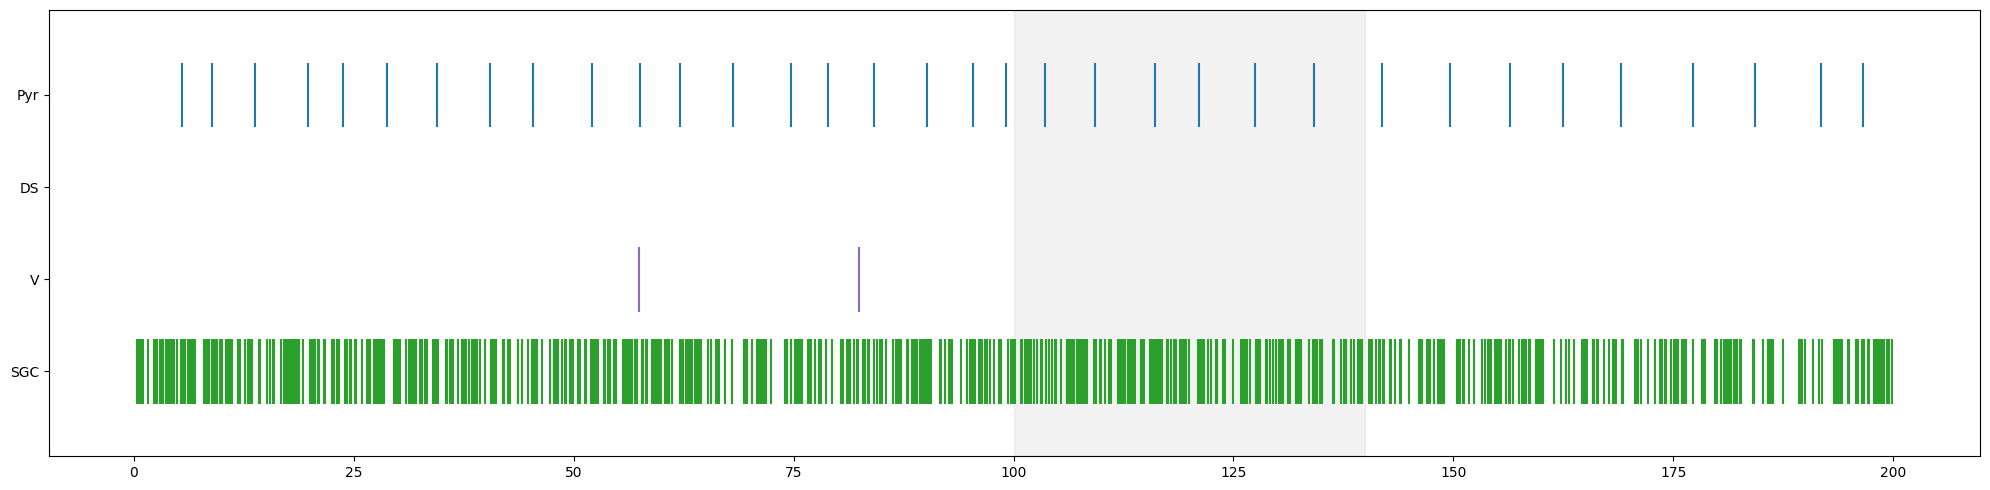

In [ ]:


cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']
cell_spkts = {cell_type: [] for cell_type in cell_types}

for cell_info, cell_data in cells[0].items():
    if isinstance(cell_info, str):
        continue
    cell_type, cell_id = cell_info
    cell_v, cell_spkt = cell_data
    # print(cell_id)

    if len(cell_spkt) > 0:
        cell_spkts[cell_type].extend(cell_spkt)

fig, axs = plt.subplots(1,1,figsize=(20,5))

axs.eventplot(list(cell_spkts.values()), colors=list(colors.values()), linelengths=0.7, zorder=12)
axs.axvspan(100, 140, color='grey', alpha=0.1, zorder=1)
axs.invert_yaxis()
axs.set_yticks([0, 1, 2, 3])
axs.set_yticklabels(['Pyr', 'DS', 'V', 'SGC'])

fig.tight_layout()

In [125]:
fmin = 4e3
fmax = 32e3
octavespacing = 1 / 8.0  # 8.0
n_frequencies = int(np.log2(fmax / fmin) / octavespacing) + 1
fvals = (
    np.logspace(
        np.log2(fmin / 1000.0),
        np.log2(fmax / 1000.0),
        num=n_frequencies,
        endpoint=True,
        base=2,
    )
    * 1000.0
)

n_levels = 11
levels = np.linspace(20, 100, n_levels) 

In [128]:
list(results_od.keys())[0]

'f0: 4000  dBspl: 20'

In [151]:
fvals

array([ 4000.        ,  4362.03093066,  4756.82846001,  5187.3582186 ,
        5656.85424949,  6168.84330163,  6727.17132203,  7336.03234564,
        8000.        ,  8724.06186132,  9513.65692002, 10374.71643721,
       11313.70849898, 12337.68660326, 13454.34264406, 14672.06469127,
       16000.        , 17448.12372264, 19027.31384004, 20749.43287442,
       22627.41699797, 24675.37320653, 26908.68528812, 29344.12938255,
       32000.        ])

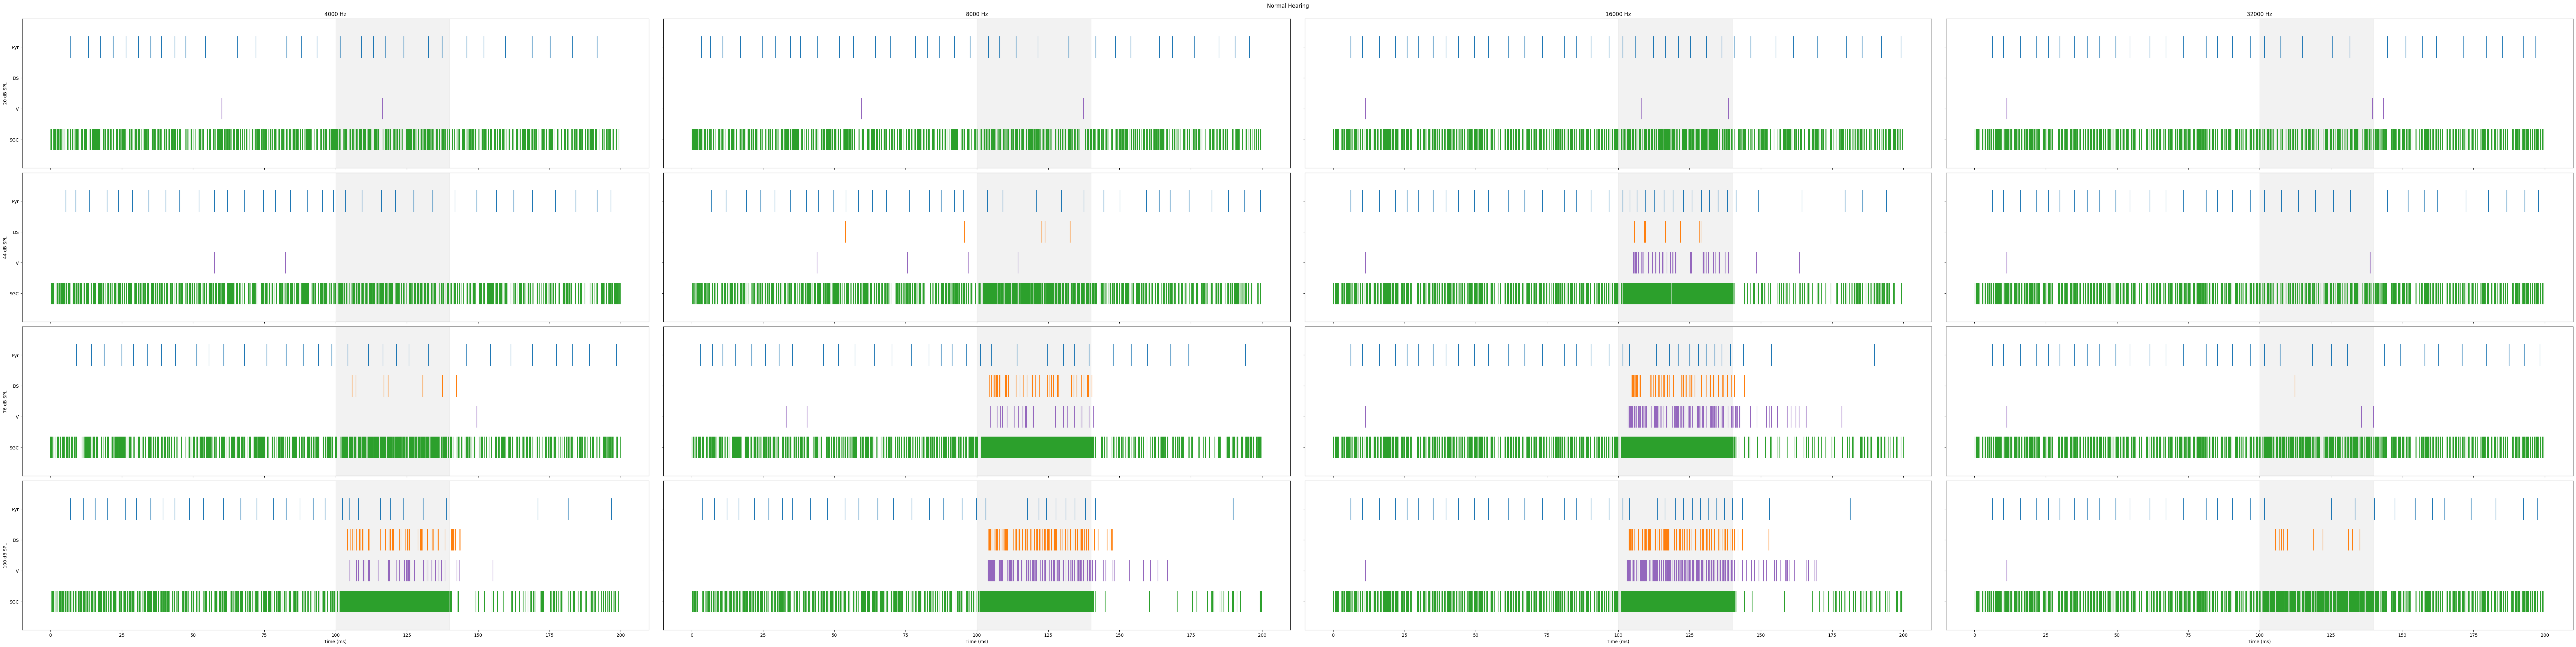

In [166]:
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

freqs = [4000, 8000, 16000, 32000]
sub_levels = [20, 44, 76, 100]

fig, axs = plt.subplots(len(sub_levels), len(freqs),figsize=(80,20), layout='constrained', sharex=True)
    # axs.ravel()

for j, freq in enumerate(freqs):
    # freq = round(freq)

    for i, level in enumerate(sub_levels):
        # level = round(level)

        cells = results_od[f'f0: {freq}  dBspl: {level}'][1][0]
        
        cell_spkts = {cell_type: [] for cell_type in cell_types}

        for cell_info, cell_data in cells.items():
            if isinstance(cell_info, str):
                continue
            cell_type, cell_id = cell_info
            cell_v, cell_spkt = cell_data
            # print(cell_id)

            if len(cell_spkt) > 0:
                cell_spkts[cell_type].extend(cell_spkt)

        axs[i,j].eventplot(list(cell_spkts.values()), colors=list(colors.values()), linelengths=0.7, zorder=12)
        axs[i,j].axvspan(100, 140, color='grey', alpha=0.1, zorder=1)
        axs[i,j].invert_yaxis()
        axs[i,j].set_yticks([0, 1, 2, 3])
        if j == 0:
            axs[i,0].set_yticklabels(['Pyr', 'DS', 'V', 'SGC'])
            axs[i,0].set_ylabel(f'{level} dB SPL')
        else:
            axs[i,j].set_yticklabels([])

    axs[0,j].set_title(f'{freq} Hz')
    axs[-1,j].set_xlabel('Time (ms)')

fig.suptitle('Normal Hearing')
fig.savefig(os.path.join('/home/kedoxey/DCN_model/output/response_maps-single_cell', '16000cf-network_raster.png'), dpi=300)



In [5]:
results_od_loss = pickle.load(open('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss/25fs_11dbs_16000cf-results_od.pkl', 'rb'))

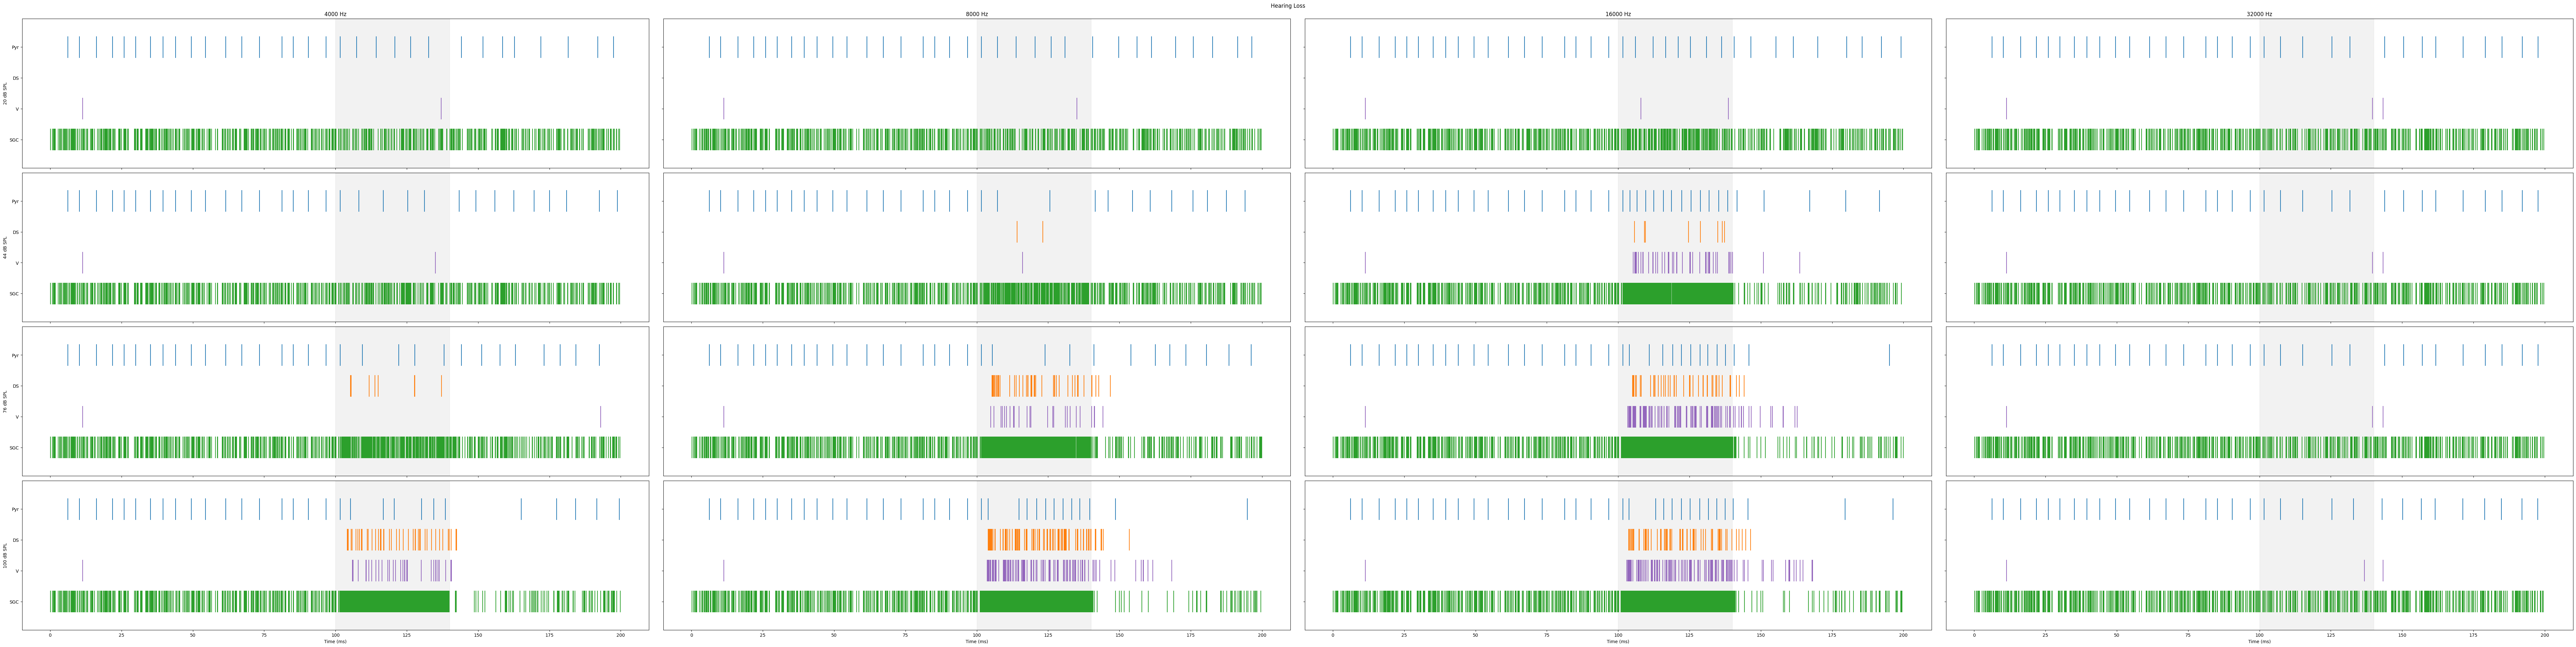

In [168]:
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

freqs = [4000, 8000, 16000, 32000]
sub_levels = [20, 44, 76, 100]

fig, axs = plt.subplots(len(sub_levels), len(freqs),figsize=(80,20), layout='constrained', sharex=True)
    # axs.ravel()

for j, freq in enumerate(freqs):
    # freq = round(freq)

    for i, level in enumerate(sub_levels):
        # level = round(level)

        cells = results_od_loss[f'f0: {freq}  dBspl: {level}'][1][0]
        
        cell_spkts = {cell_type: [] for cell_type in cell_types}

        for cell_info, cell_data in cells.items():
            if isinstance(cell_info, str):
                continue
            cell_type, cell_id = cell_info
            cell_v, cell_spkt = cell_data
            # print(cell_id)

            if len(cell_spkt) > 0:
                cell_spkts[cell_type].extend(cell_spkt)

        axs[i,j].eventplot(list(cell_spkts.values()), colors=list(colors.values()), linelengths=0.7, zorder=12)
        axs[i,j].axvspan(100, 140, color='grey', alpha=0.1, zorder=1)
        axs[i,j].invert_yaxis()
        axs[i,j].set_yticks([0, 1, 2, 3])
        if j == 0:
            axs[i,0].set_yticklabels(['Pyr', 'DS', 'V', 'SGC'])
            axs[i,0].set_ylabel(f'{level} dB SPL')
        else:
            axs[i,j].set_yticklabels([])

    axs[0,j].set_title(f'{freq} Hz')
    axs[-1,j].set_xlabel('Time (ms)')

fig.suptitle('Hearing Loss')
fig.savefig(os.path.join('/home/kedoxey/DCN_model/output/response_maps-single_cell_loss', '16000cf-network_raster.png'), dpi=300)



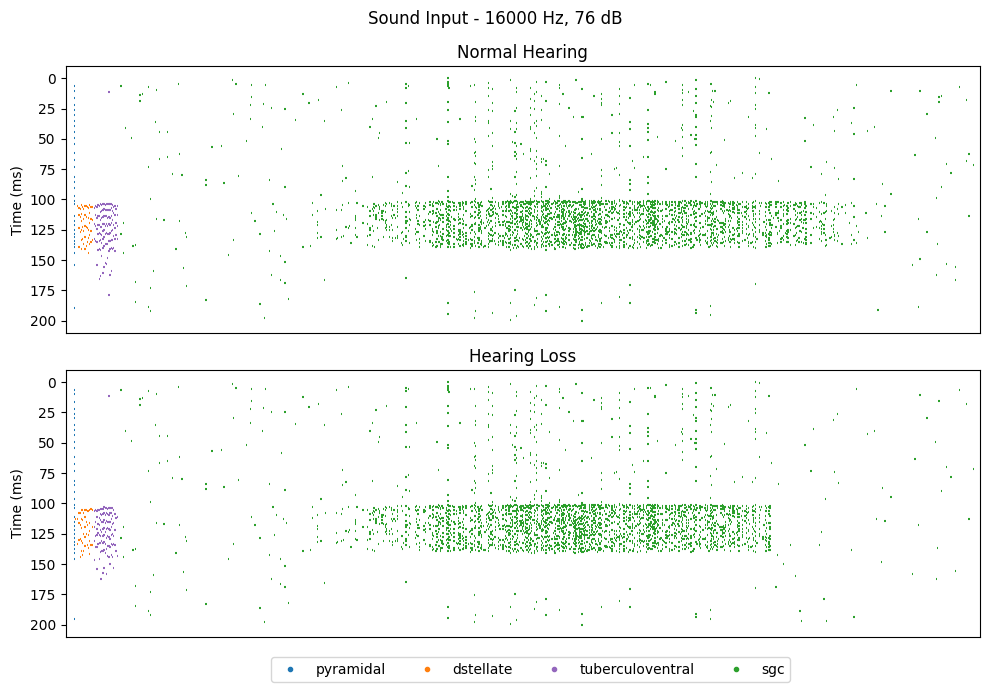

In [37]:

fig, axs = plt.subplots(2,1,figsize=(10,7))
axs = axs.ravel()
cell_types = ['pyramidal', 'dstellate', 'tuberculoventral', 'sgc']

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

freq = 16000
level = 76

cell_count = 0
cells = results_od[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    cell_type = vec[0][0]
    if isinstance(vec[0], str):
        continue
    spikes = vec[1][1]

    axs[0].hlines(spikes, xmin=cell_count-0.25, xmax=cell_count+3, colors=colors[cell_type], zorder=12)
    cell_count += 3

# axs[0].axvspan(100, 140, color='grey', alpha=0.05, zorder=1)
axs[0].set_xlim([-20, 2270])
axs[0].set_xticks([])
axs[0].set_ylabel('Time (ms)')
axs[0].invert_yaxis()
axs[0].set_title('Normal Hearing')

cell_count = 0
cells = results_od_loss[f'f0: {freq}  dBspl: {level}'][1][0]

for vec in cells.items():
    temp = 7
    cell_type = vec[0][0]
    if isinstance(vec[0], str):
        continue
    spikes = vec[1][1]

    axs[1].hlines(spikes, xmin=cell_count-0.25, xmax=cell_count+3, colors=colors[cell_type], zorder=12)
    cell_count += 3

# axs[1].axvspan(100, 140, color='grey', alpha=0.05, zorder=1)
# axs[1].set_xlabel('Time (ms)')
axs[1].set_xlim([-20,2270])
axs[1].set_xticks([])
axs[1].set_ylabel('Time (ms)')
axs[1].invert_yaxis()
axs[1].set_title('Hearing Loss')

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], marker='.', color=val, lw=0, label=key) for key, val in list(colors.items())]
axs[1].legend(handles=custom_lines, loc='upper right', ncol=len(colors), bbox_to_anchor=(0.8, -0.05))

fig.suptitle(f'Sound Input - {freq} Hz, {level} dB')

fig.tight_layout()



NameError: name 'cell_spkts' is not defined

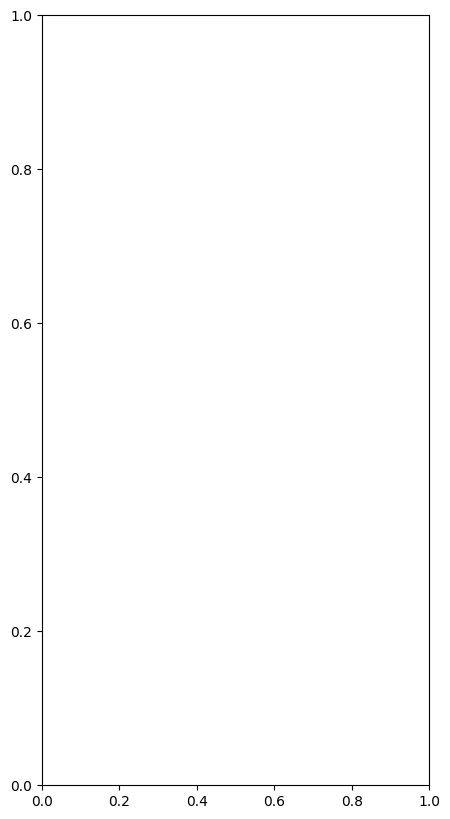

In [23]:
fig, axs = plt.subplots(1,1,figsize=(5,10))
# axs = axs.ravel()

colors = {'pyramidal': 'tab:blue',
          'dstellate': 'tab:orange',
          'tuberculoventral': 'tab:purple',
          'sgc': 'tab:green'}

cell_count = 0

for cell_type, cell_data in cell_spkts.items():


    for spkts in cell_data:

        axs.vlines(spkts[1], ymin=-cell_count-0.25, ymax=-cell_count+1, colors=colors[cell_type], zorder=12)
        cell_count += 2

    # axs.plot([100, 140], [5, 5], color='k')
    axs.axvspan(100, 140, color='grey', alpha=0.05, zorder=1)
        
axs.set_xlabel('Time (ms)')
axs.set_ylim([-505, 5])
fig.tight_layout()

# axs.set_title(cell_type)
    # axs[i].set_ylim([0,250])
